# Discharge, Reaccretion, and impacts of Supernovae (Part 1 /2):
## Concerning Satellite Infall
`-- Leo Lonzarich, 27 January 2022 // [Updated 14-3-22] --`

---

### Table of Contents
- [Defining Infall](#infall)
    - [Discharge and Reaccretion](#disreacc)
    - [Identifying Ram Pressures](#ramdis)
- [Assessing Gas Flows](#flows)
    - [Discharged/Reaccreted](#reaccreted)
    - [Discharged/All](#discharged)
    - [Fractions of Rates](#fracs)
    - [Gas Fractions](#fractions)
    - [Inflows, Outflows, and Net](#inout)
- [Disk Mass](#diskmass)
- [Discriminating Between Satellites](#disc)




   


### General Comments on Data/Contents of this Noteboook
- This is the first installment of work tied to Spring 2022 research under **Professor Charlotte Christensen** (Grinnell College, IA)
- See `SimKeys.md` for comprensive explanation of intrinsic particle properties (as found when calling `[particles].keys()`) and standard units of measure.


**The Data (Lonzarich):**

- `discharged`: Gas particles that have been removed from the disk of their respective satellite galaxy. This includes both gas moved to halo, and that moved beyond the virial radius. (Properties given for **timestep after discharge event**.)
- `predischarged`: A collection of the same particles in `discharged`, but instead giving the properties of each particle prior to their discharge event (thereby allowing pre- and post-discharge comparisons).
- `heated`: Gas particles in `discharged` that experienced supernova(e) heating (functionally, their 'cooling' was turned off) in the timestep prior to being discharged. (Note: this dataset can be also be obtained by selecting particles from `discharged` with `sneHeated==True`.)
- `preheated`: Similar to `predischarged`; Consists of the same particles in `heated`, but with properties of each particle for the timestep prior to discharge.
<br><br>
- `accreted`: Gas particles in the halo or beyond the virial radius of a satellite that are accreted onto the satellite's disk. (Properties given for **timestep following accretion event**.) Note that this includes particles that were previously discharged from the satellite's disk, and those that were not. 
- `reaccreted`: A subset of `accreted`; Gas particles in the halo or beyond the virial radius of a satellite as a result of a prior discharge event that are reaccreted onto the satellite's disk. (Properties given for **timestep following reaccretion event**.)


In [1]:
import pylab
import pynbody
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import gridspec


from astropy import units
from astropy import constants as c

import warnings
warnings.filterwarnings("ignore")

from compiler import *
from analysis import *


In [2]:
# helpful fix in case TeX breaks in pyplots.
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [3]:
# quick check to ensure all selected gas particles are accounted for.
path = f'{rootPath}Stellar_Feedback_Code/SNeData/discharged_particles.hdf5'
with pd.HDFStore(path) as hdf:
    keys = np.array([h[1:] for h in hdf.keys()])

print(len(keys), 'Available Keys:\n', *keys)

19 Available Keys:
 h148_12 h148_249 h148_251 h148_27 h148_282 h148_34 h148_38 h148_55 h148_65 h229_14 h229_18 h229_20 h229_22 h229_49 h242_21 h242_38 h242_69 h329_117 h329_29


## Establishing Infall Distance to Satellite Host  <a class="anchor" id="infall"></a>

#### Why?

To kickoff the second stage in SNe feedback analysis, we are first required to identify location during satellite infall for each gas particle. When a distant dwarf galaxy becomes gravitationally bound to a Milky-Way-mass host galaxy, it develops an approach vector oriented towards the COM of the host -- it is this approach to the host COM that we term "satellite infall", and it is the distance of the satellite's COM to the host's COM that we define as "point at infall". 

Thus, for each gas particle, we wish to find point at infall with the end goal being that this allows us to more readily discriminate between gas particles. What is more, however, we know from past work (see Akins et al. 2021) that ram pressure stripping (RPS) efficiency increases with proximity of a satellite galaxy to its host. Therefore, discriminating on point at infall presents a method for screening gas for RPS and possibly untangle RPS from SNe feedback stripping mechanisms.

#### How? 

Locating point at infall data, which we will lovingly term PAI (or `pai`), is a relatively straightforward excercise, and we will normalize `pai` by the virial radius of the host galaxy, `Rvir`, which will effectively give us a percent distance of a gas particle's satellite to the center of its host:

$$
pai = \frac{\text{radial distance from sat. to host}}{\text{virial radius of host}} .
$$
____
____

### Effects of POI on Discharge, Reaccretion  <a class="anchor" id="disreacc"></a>

___

In [4]:
# importing gas selection:
predischarged, discharged, preheated, heated = read_all_discharged()
accreted, reaccreted = read_accreted()

> Returning (predischarged, discharged, preheated, heated) for all satellites <
> Returning (accreted, reaccreted) for all satellites <


In [5]:
discharged.keys()

Index(['time', 'pid', 'rho', 'temp', 'mass', 'coolontime', 'r', 'r_per_Rvir',
       'x', 'y', 'z', 'satRvir', 'a', 'vx', 'vy', 'vz', 'v', 'r_rel_host',
       'r_rel_host_per_Rvir', 'x_rel_host', 'y_rel_host', 'z_rel_host',
       'hostRvir', 'vx_rel_host', 'vy_rel_host', 'vz_rel_host', 'v_rel_host',
       'sat_Xc', 'sat_Yc', 'sat_Zc', 'sat_vx', 'sat_vy', 'sat_vz', 'host_Xc',
       'host_Yc', 'host_Zc', 'host_vx', 'host_vy', 'host_vz', 'sat_Mstar',
       'sat_Mgas', 'host_Mstar', 'host_Mgas', 'sat_r_half', 'sat_r_gas',
       'host_r_half', 'host_r_gas', 'in_sat', 'in_host', 'in_other_sat',
       'in_IGM', 'dt', 'r_gal', 'host_r_gal', 'sat_disk', 'sat_halo',
       'host_disk', 'host_halo', 'other_sat', 'IGM', 'sat_Mvir', 'angle',
       'sneHeated', 'key'],
      dtype='object')

In [6]:
# callable derivation for satellite distance from host:
@pynbody.derived_array
def pai(gas):
    return np.array(np.sqrt((gas['host_Xc'] - gas['sat_Xc'])**2 
                            + (gas['host_Yc'] - gas['sat_Yc'])**2 
                            + (gas['host_Zc'] - gas['sat_Zc'])**2 
                           )/ gas['hostRvir']
                   )

# quick calc. for ubiquitous weights in plotting.
@pynbody.derived_array
def wt(*gas):
    if len(gas) == 1:
        return np.array(gas[0]['mass'] / gas[0]['mass'].sum())
    
    else:
        return np.array(gas[0]['mass'] / gas[1]['mass'].sum())

Notes on terminology:
- We use $\sum M_{dsrg}$ and $\sum M_{reacc}$ to denote the cumulative mass of all discharged and reaccreted gas particles, respectively.
- $R_{vir}$ is the virial radius of the host galaxy.
- $M_{\{gas\}}$ refers to the mass of gas either discharged or reaccreted (where applicable in the plots) corresponding to a particular parameter.

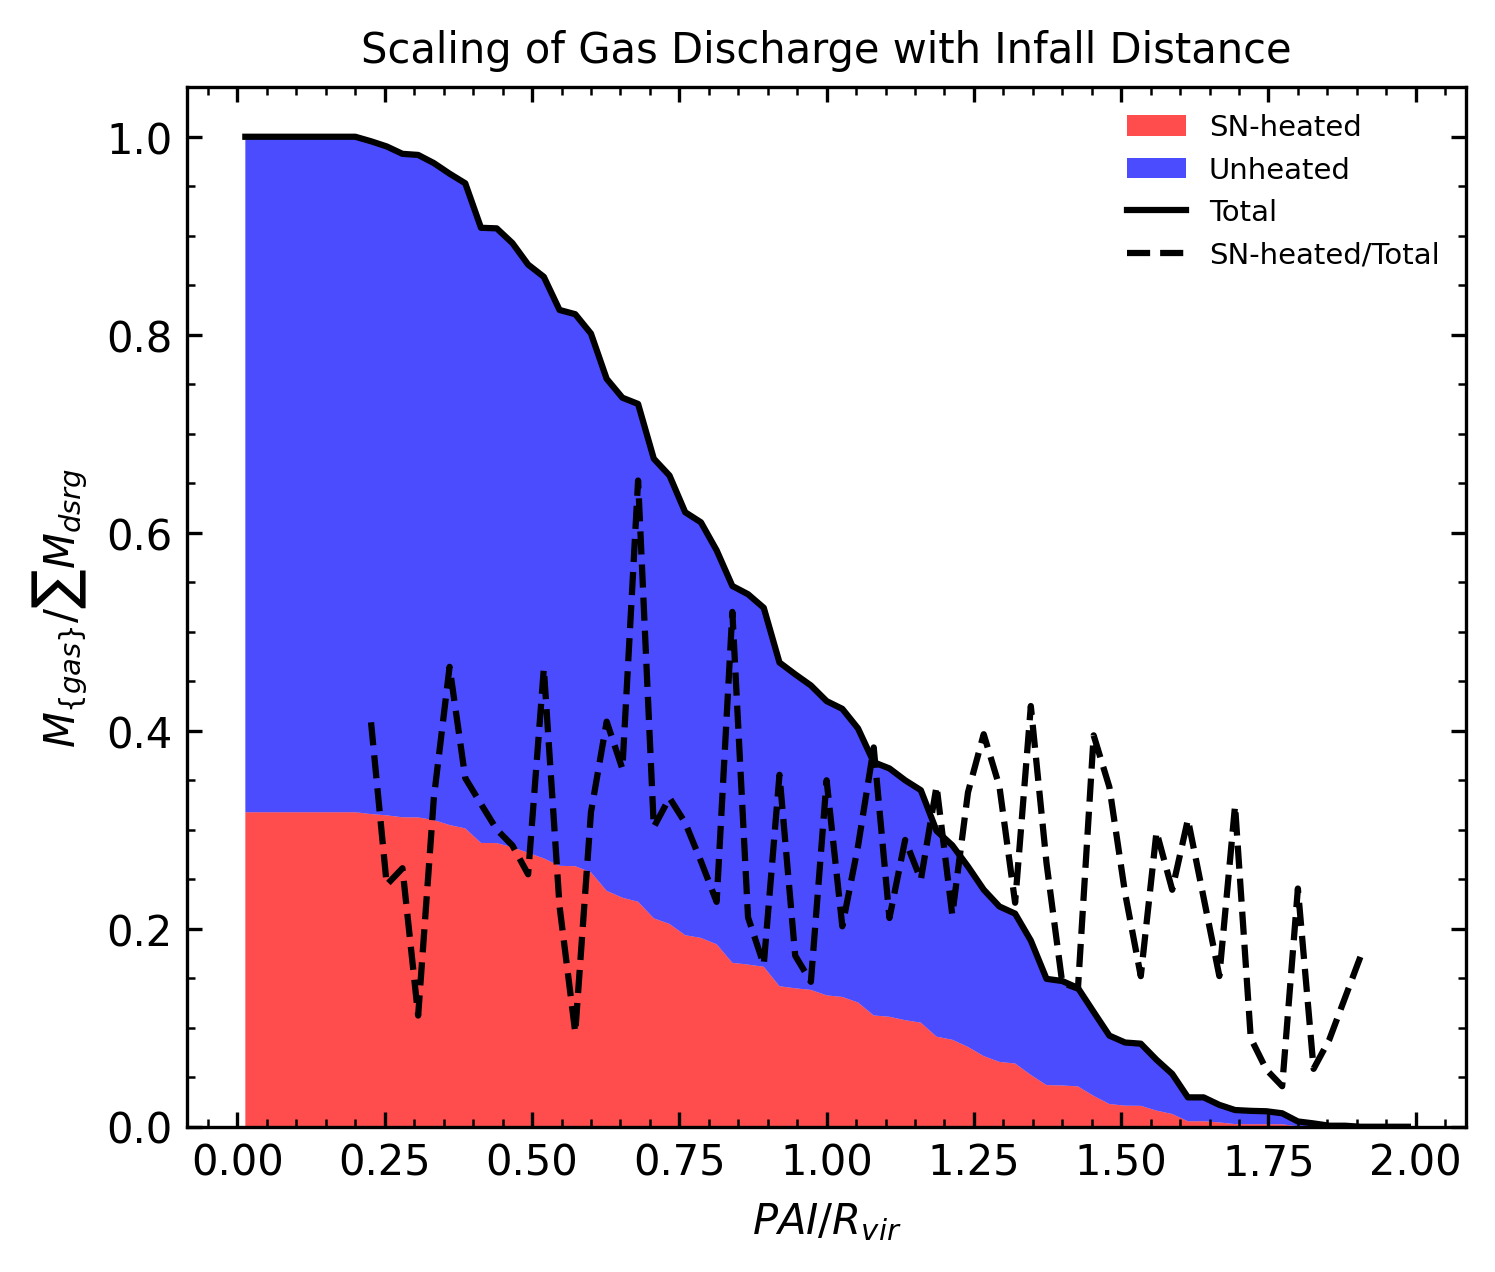

In [15]:
### Using for Paper ###
#######################

# where discharged gas is removed to as a function of PAI.
hot = discharged[discharged.sneHeated==True]
cold = discharged[discharged.sneHeated==False]


bins = 75
fig, ax = plt.subplots(1,1, dpi=300, figsize=(5.5,4.5), sharex=True,
                       constrained_layout=False)

y1, x = np.histogram(pai(hot), bins=bins, weights=wt(hot,discharged),
                     range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)
y2, x = np.histogram(pai(cold), bins=bins, weights=wt(cold,discharged),
                     range=(0, 2))
sum2 = np.cumsum(y2)
ax.stackplot(bincenters, sum1[-1]-sum1, sum2[-1]-sum2, alpha=0.7,
             colors=['r', 'b'], labels=['SN-heated', 'Unheated'])         

y3, x = np.histogram(pai(discharged), bins=bins, weights=wt(discharged),
                     range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum3 = np.cumsum(y3)
ax.plot(bincenters, sum3[-1]-sum3, alpha=1.0, c='black', label='Total')

ax.plot(bincenters[y3>0], (y1/y3)[y3>0], linestyle='--', c='black', label='SN-heated/Total')

ax.set_title('Scaling of Gas Discharge with Infall Distance', fontsize='medium')
ax.set_xlabel(r'$PAI / R_{vir}$')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{dsrg}$')
# # ax[1].set_xlim(-0.1,4)
# ax[1].set_ylim(0,0.2)

ax.tick_params(direction='in', which='both', top=True, right=True)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
# ax.grid(alpha=0.1, zorder=-1000)

ax.legend(frameon=False, fontsize=7)

plt.savefig('plots/PAIperRvir.pdf')
plt.show()

In [20]:
# computing avg. of SN-heated/Total (dashed line in above plot):
(y1/y3)[y3>0].mean()

0.27219090255073675

Note: The rising edge that appears between ~1.50 and 2.00 $PAI/R_{vir}$ is likely due to the low relative particle counts in this region.

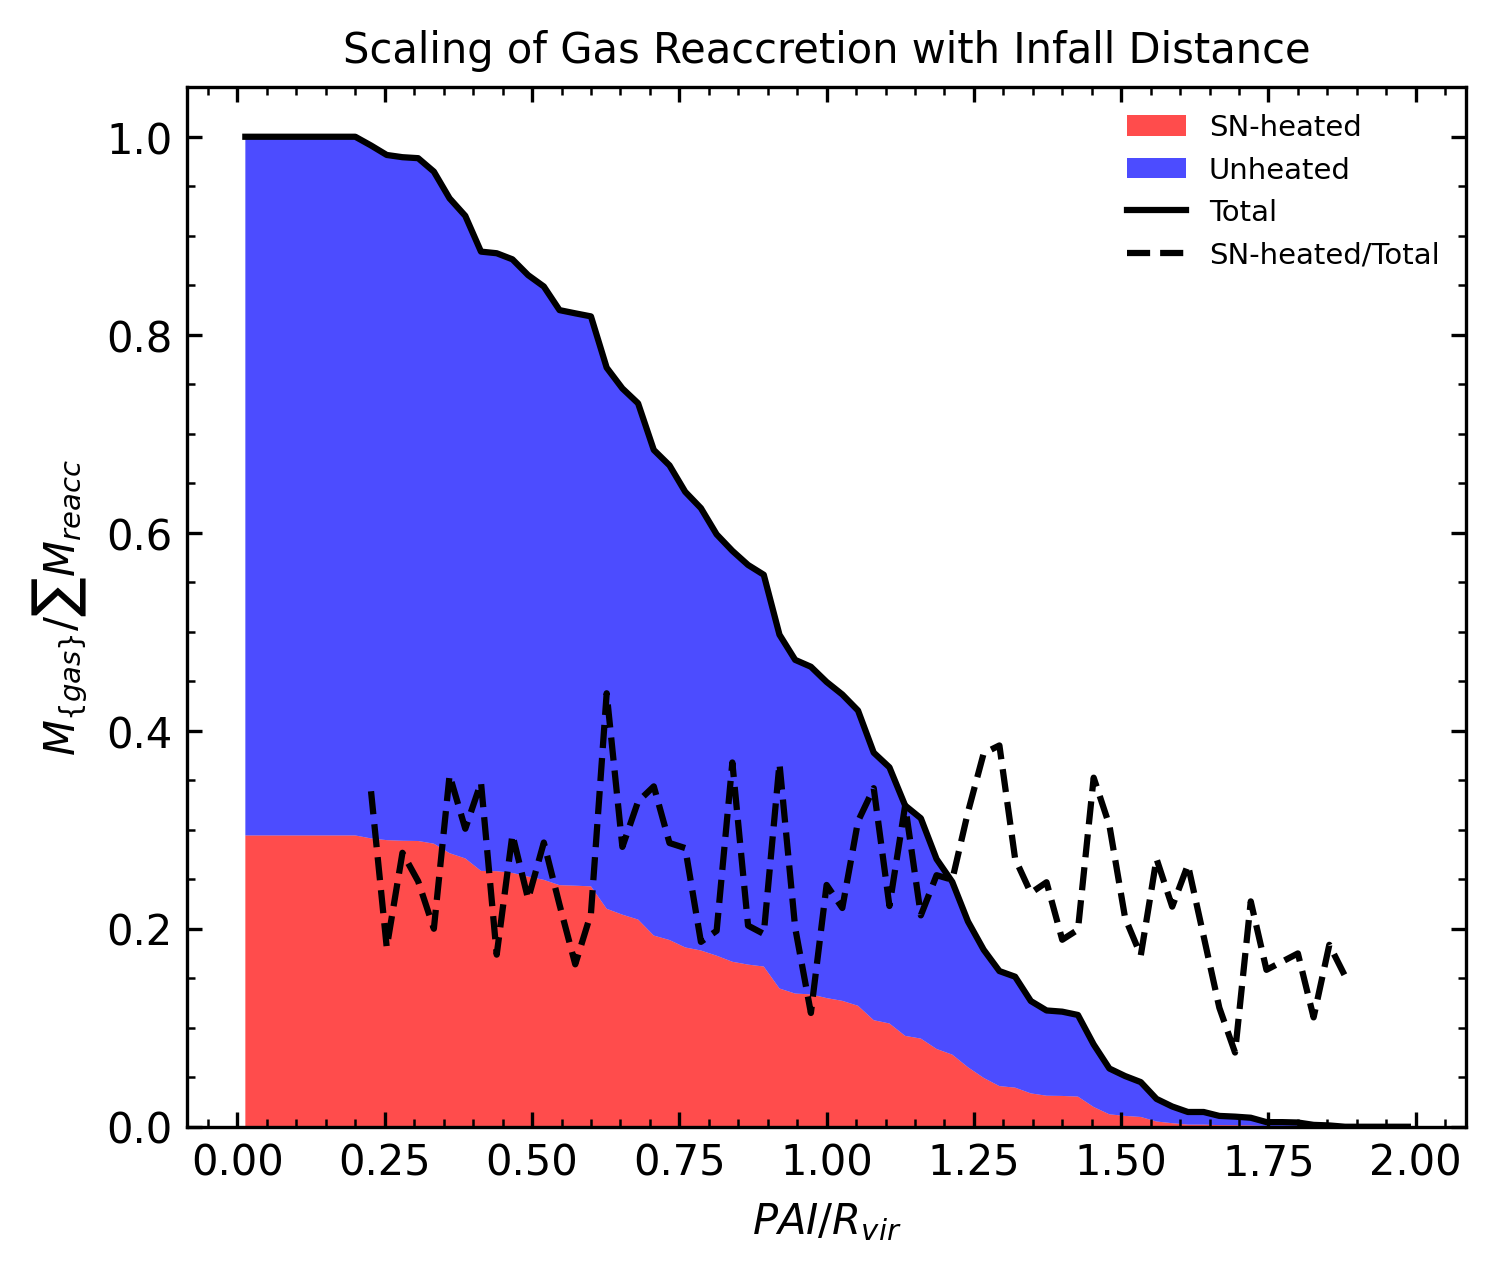

In [78]:
# Basic visualization of where reaccreted gas is removed to as function of POI.
hot = reaccreted[reaccreted.sneHeated==True]
cold = reaccreted[reaccreted.sneHeated==False]

bins = 75
fig, ax = plt.subplots(1,1, dpi=300, figsize=(5.5,4.5), sharex=True,
                       constrained_layout=False)


y1, x = np.histogram(pai(hot), bins=bins, weights=wt(hot,reaccreted),
                     range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)
y2, x = np.histogram(pai(cold), bins=bins, weights=wt(cold,reaccreted),
                     range=(0, 2))
sum2 = np.cumsum(y2)
ax.stackplot(bincenters, sum1[-1]-sum1, sum2[-1]-sum2, alpha=0.7,
             colors=['r', 'b'], labels=['SN-heated', 'Unheated'])         

y3, x = np.histogram(pai(reaccreted), bins=bins, weights=wt(reaccreted), 
                     range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum3 = np.cumsum(y3)
ax.plot(bincenters, sum3[-1]-sum3, alpha=1.0, c='black', label='Total')

ax.plot(bincenters[y3>0], (y1/y3)[y3>0], linestyle='--', c='black', label='SN-heated/Total')

ax.set_title('Scaling of Gas Reaccretion with Infall Distance',
             fontsize='medium')
ax.set_xlabel(r'$PAI / R_{vir}$')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{reacc}$')
# # ax[1].set_xlim(-0.1,4)
# ax[1].set_ylim(0,0.2)

ax.tick_params(direction='in', which='both', top=True, right=True)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
# ax.grid(alpha=0.1, zorder=-1000)

ax.legend(frameon=False, fontsize=7)

plt.savefig('plots/PAIperRvir_reac.pdf')
plt.show()

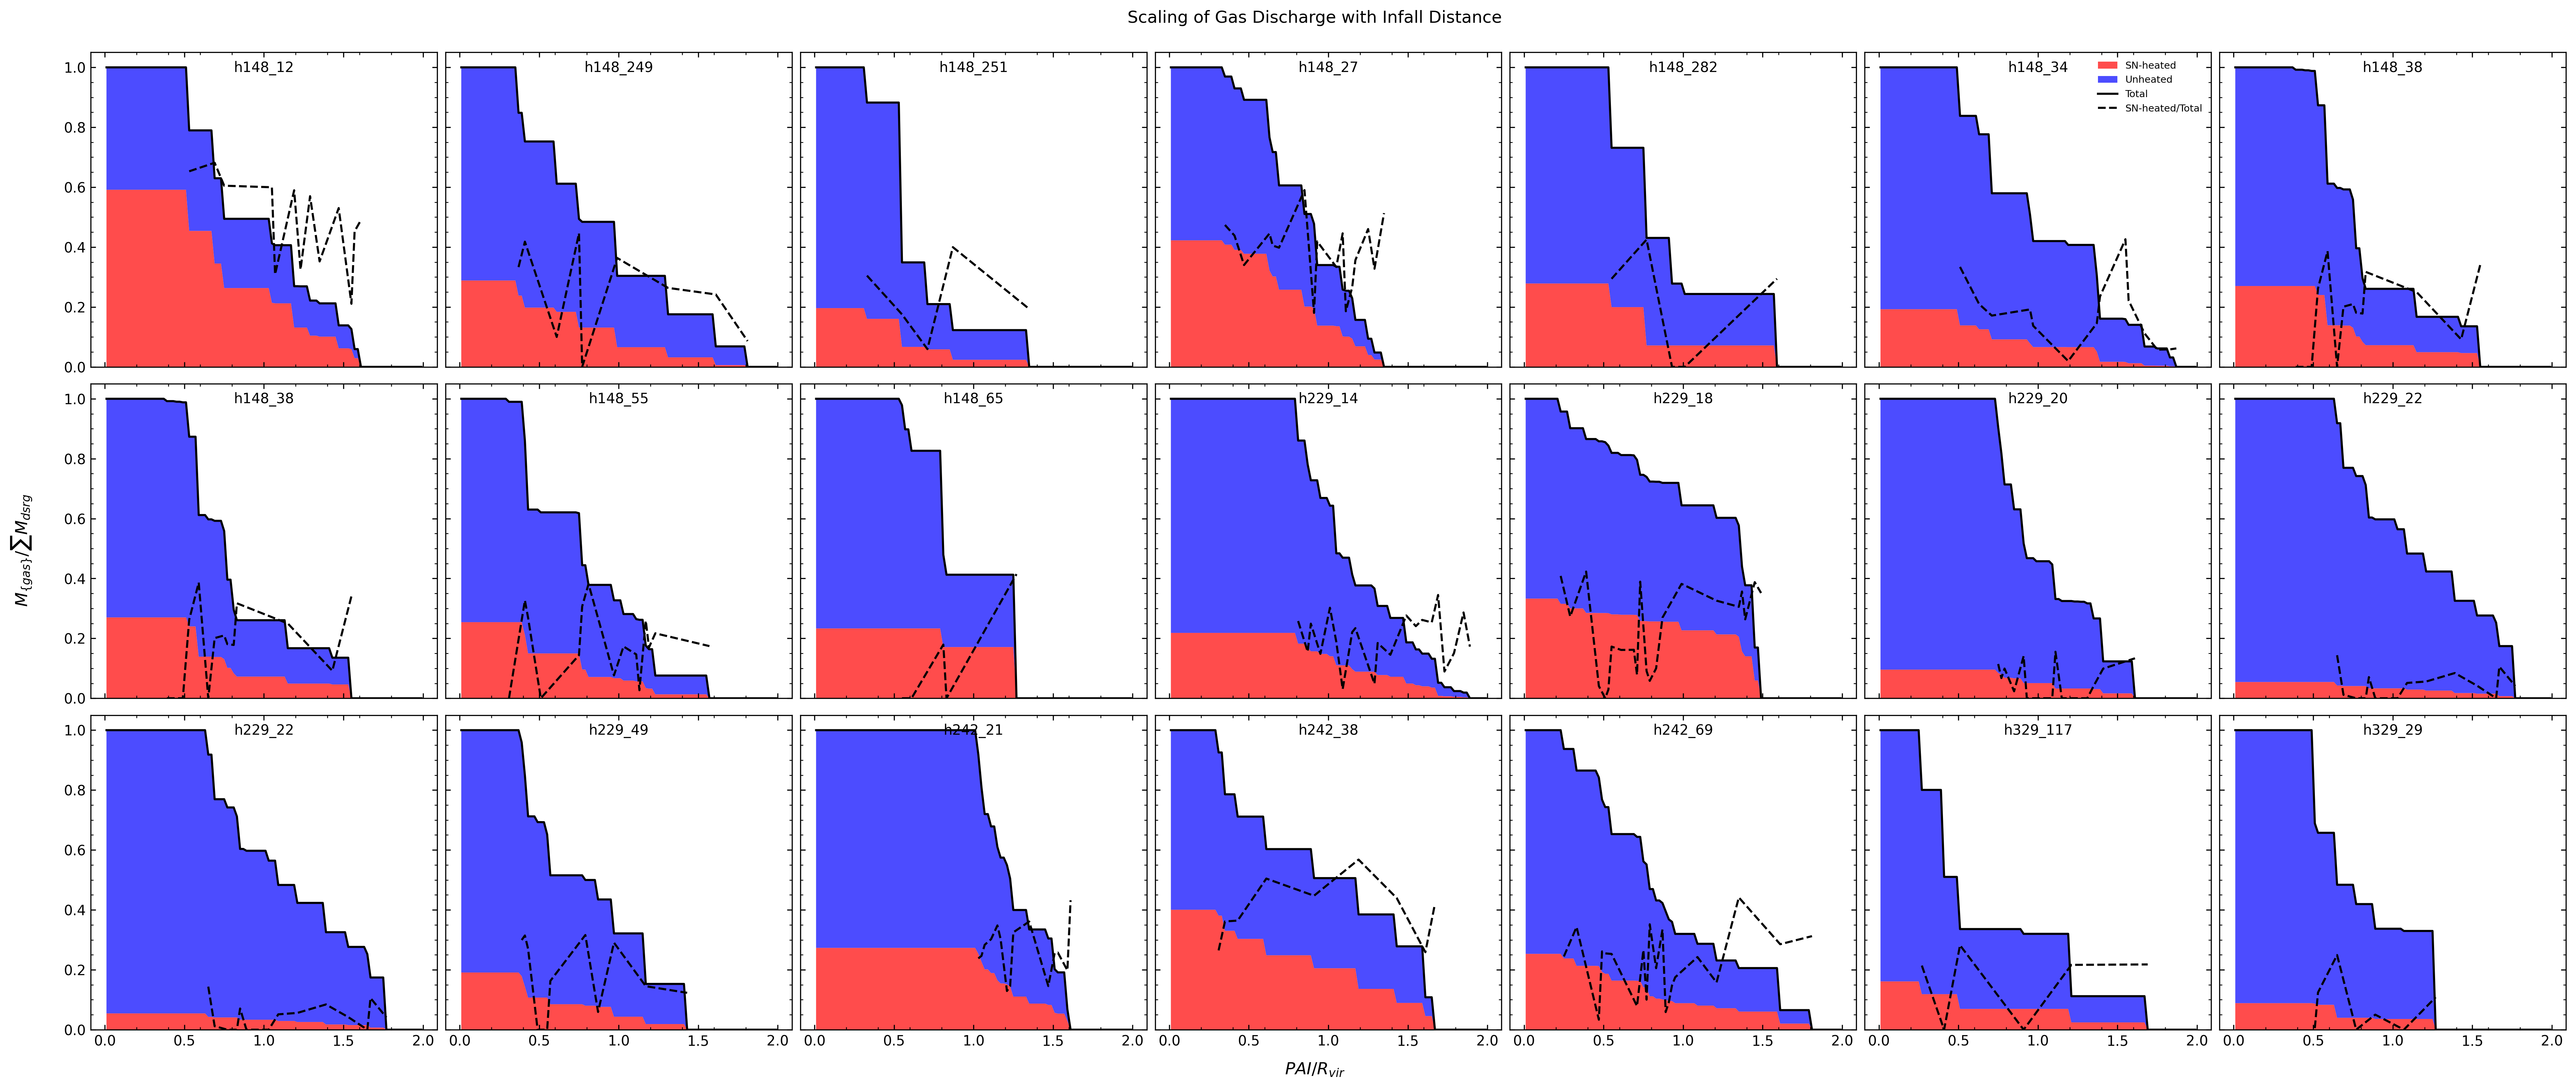

In [45]:
### Using for Paper ###
#######################

# Making panels of the discharge plots above for each satellite.

# where discharged gas is removed to as a function of PAI.
hot = discharged[discharged.sneHeated==True]
cold = discharged[discharged.sneHeated==False]

# running loop for each sat.
bins = 100
fig, ax = plt.subplots(3, 7, dpi=300, figsize=(25,10), sharex='col', sharey='row', 
                       constrained_layout=True)  # figsize=(20,10)

for i in range(3): 
    for j in range(0,7):
        k = 6*i + j # for efficiently cycling throught all satellite keys.
        
        hot1 = hot[hot['key']==keys[k]]
        cold1 = cold[cold['key']==keys[k]]
        discharged1 = discharged[discharged['key']==keys[k]]

        y1, x = np.histogram(pai(hot1), bins=bins, weights=wt(hot1,discharged1),
                             range=(0, 2))
        bincenters = 0.5*(x[1:] + x[:-1])
        sum1 = np.cumsum(y1)
        y2, x = np.histogram(pai(cold1), bins=bins, weights=wt(cold1,discharged1),
                             range=(0, 2))
        sum2 = np.cumsum(y2)
        ax[i, j].stackplot(bincenters, sum1[-1]-sum1, sum2[-1]-sum2, alpha=0.7,
                     colors=['r', 'b'], labels=['SN-heated', 'Unheated'])

        y3, x = np.histogram(pai(discharged1), bins=bins, weights=wt(discharged1),
                             range=(0, 2))
        bincenters = 0.5*(x[1:] + x[:-1])
        sum3 = np.cumsum(y3)
        ax[i, j].plot(bincenters, sum3[-1]-sum3, alpha=1.0, c='black', label='Total')

        ax[i, j].plot(bincenters[y3>0], (y1/y3)[y3>0], linestyle='--', c='black',
                   label='SN-heated/Total')
        
        # setting axes, titles, etc.
        ax[i, j].set_title(f'{keys[k]}', fontsize='medium', y=1.0, pad=-14)
        
        ax[i, j].tick_params(direction='in', which='both', top=True, right=True)
        ax[i, j].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))
        ax[i, j].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))

        
# single title, x- and y-axis labels.
# plt.subplots_adjust(bottom=0.2)
fig.text(0.5, 1.03, 'Scaling of Gas Discharge with Infall Distance', ha='center',
         va='center', fontsize='large')

fig.text(0.5, -0.017, '$PAI / R_{vir}$', ha='center', va='center', fontsize='large')
fig.text(-0.015, 0.5, '$M_{\{gas\}} / \sum M_{dsrg}$', ha='center', va='center',
         rotation='vertical', fontsize='large')

ax[0, 5].legend(frameon=False, fontsize=7)

plt.savefig('plots/PAIperRvir_panel.pdf')
plt.show()

## SN-heated Gas Fractions, Gas Flows <a class="anchor" id="flows"></a>

We give two treatments in this section:
1. Fraction of SN-heated, discharged gas reaccreted at each $PAI/R_{vir}$;

2. Fraction of all SN-heated gas discharged from its satellite (again, at each $PAI/R_{vir}$)
___
___


### SN-heated, Reaccreted Gas / SN-heated, Discharged Gas [WIP]<a class="anchor" id="reaccreted"></a>
___

In [60]:
hot = discharged[discharged.sneHeated==True]
cold = discharged[discharged.sneHeated==False]

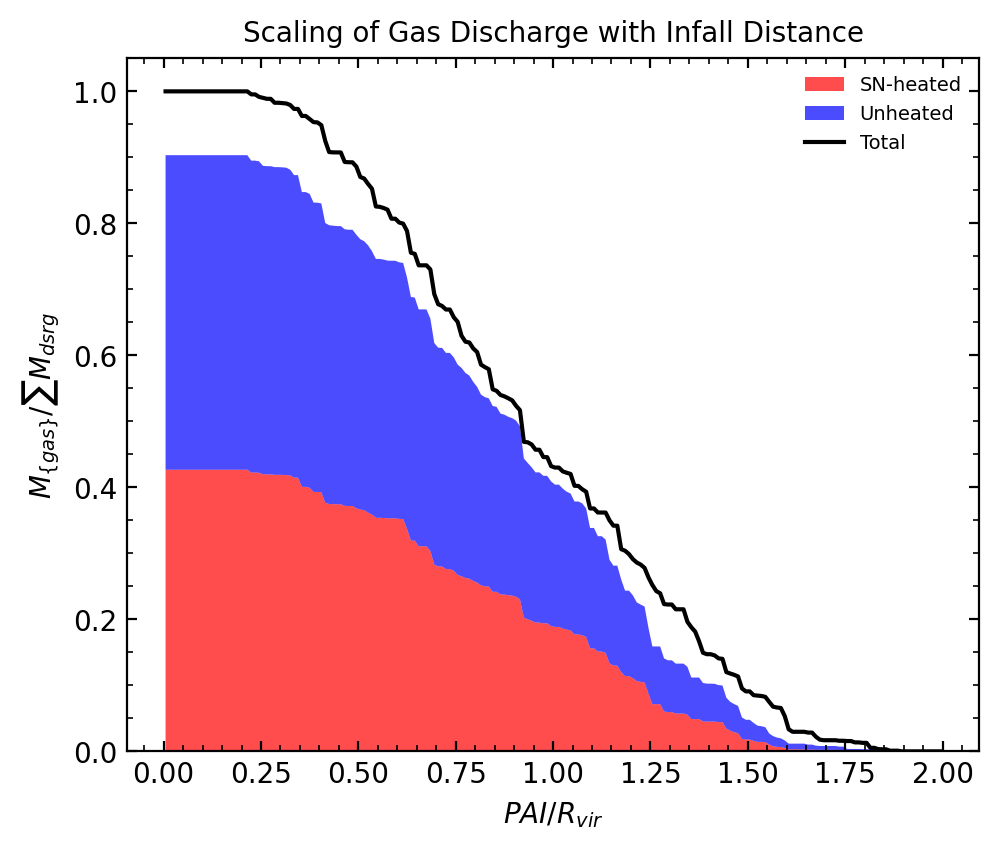

In [61]:
# plotting hot reaccreted per hot discharged.
hot_dsrg = discharged[discharged.sneHeated==True]
cold_dsrg = discharged[discharged.sneHeated==False]
hot_reac = reaccreted[reaccreted.sneHeated==True]
cold_reac = reaccreted[reaccreted.sneHeated==False]


bins = 200
fig, ax = plt.subplots(1,1, dpi=200, figsize=(5.5,4.5), sharex=True,
                       constrained_layout=False)

y1, x = np.histogram(pai(hot_reac), bins=bins, weights=wt(hot_reac,hot_dsrg),
                     range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)
y2, x = np.histogram(pai(cold_reac), bins=bins, weights=wt(cold_reac,cold_dsrg), 
                   range=(0, 2))
sum2 = np.cumsum(y2)
ax.stackplot(bincenters, sum1[-1]-sum1, sum2[-1]-sum2, alpha=0.7,
             colors=['r', 'b'], labels=['SN-heated', 'Unheated'])         

y3, x = np.histogram(pai(discharged), bins=bins, weights=wt(discharged),
                     range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum3 = np.cumsum(y3)
ax.plot(bincenters, sum3[-1]-sum3, alpha=1.0, c='black', label='Total')

ax.set_title('Scaling of Gas Discharge with Infall Distance', fontsize='medium')
ax.set_xlabel(r'$PAI / R_{vir}$')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{dsrg}$')
# # ax[1].set_xlim(-0.1,4)
# ax[1].set_ylim(0,0.2)
                                                                                    
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
# ax.grid(alpha=0.1, zorder=-1000)

ax.legend(frameon=False, fontsize=7)

plt.show()

### SN-heated, Discharged Gas / SN-heated Gas <a class="anchor" id="discharged"></a>
___

Plotting Proportion of SN-heated gas discharged per all SN-heated gas at each PAI.

In [42]:
# reading in all SN-heated gas (both discharged and not).
sntotal = pd.DataFrame()

keys = get_keys()

for i,key in enumerate(keys):
    i += 1
    sim = key[:4]
    haloid = int(key[5:])
    sntotal1 = pd.read_hdf(f'{rootPath}Stellar_Feedback_Code/SNeData/sngas_particles.hdf5',
                           key=key)
    sntotal1['key'] = key
    sntotal = pd.concat([sntotal, sntotal1])

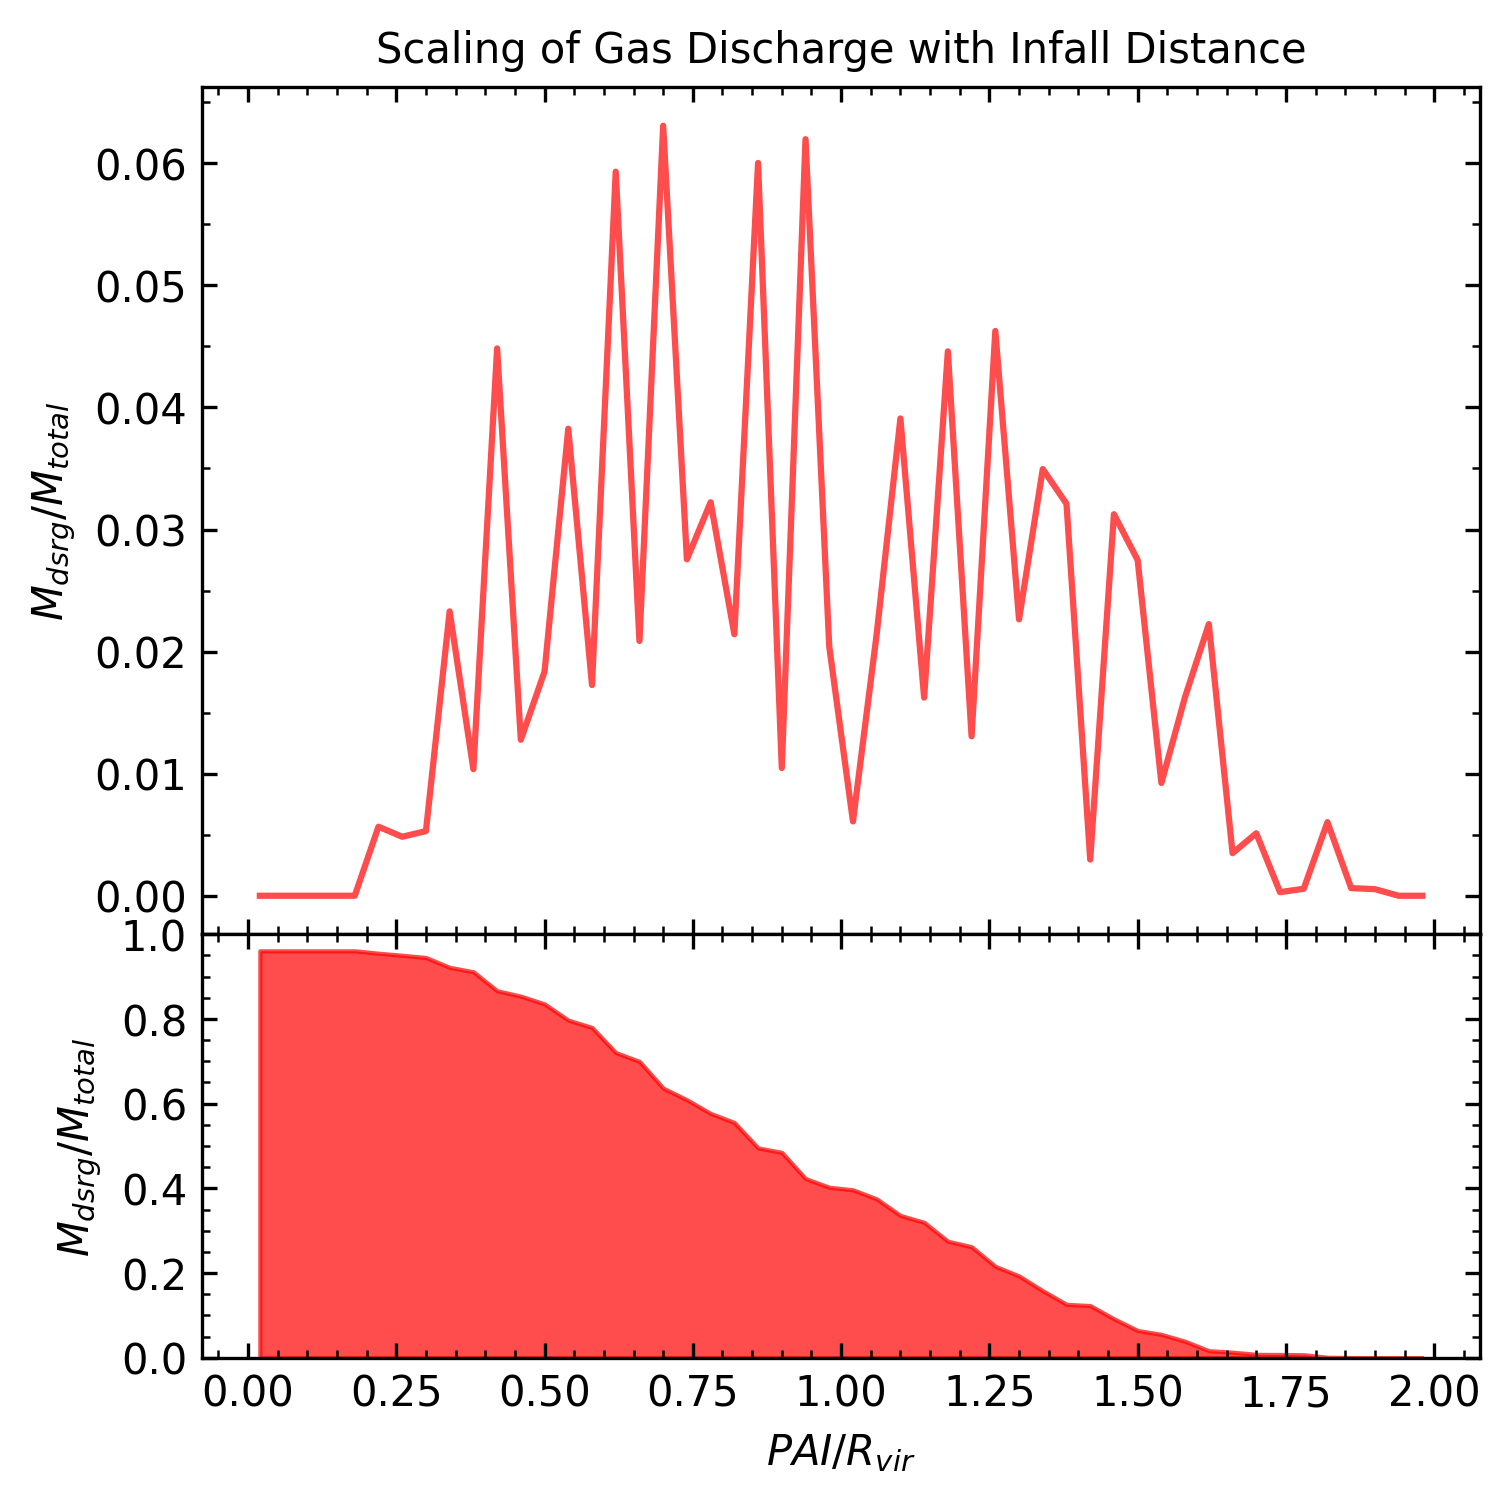

In [12]:
### Using for Paper ###
#######################

# plotting hot reaccreted per hot discharged.
hot_dsrg = discharged[discharged.sneHeated==True]
hot_reac = reaccreted[reaccreted.sneHeated==True]


bins = 50
fig = plt.figure(dpi=300, figsize=(5.5,5.5), constrained_layout=True)
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1], hspace=0) 
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1], sharex=ax0)


y1, x = np.histogram(pai(hot_dsrg), bins=bins, weights=wt(hot_dsrg, sntotal),
                     range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)

ax0.plot(bincenters, y1, alpha=0.7, color='r')         
ax1.stackplot(bincenters, sum1[-1]-sum1, alpha=0.7, color='r')    

# ax[1].text(0, 0.9, 'Accumulation of Discharged Gas with Infall Distance')


ax0.set_title('Scaling of Gas Discharge with Infall Distance', fontsize='medium')
ax0.set_xlabel(r'$PAI / R_{vir}$')
ax0.set_ylabel('$M_{dsrg} / M_{total}$')
# # ax[1].set_xlim(-0.1,4)
# ax[1].set_ylim(0,0.2)
                                                                                    
ax0.tick_params(direction='in', which='both', top=True, right=True)
ax0.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax0.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.005))
# ax.grid(alpha=0.1, zorder=-1000)

ax1.set_xlabel(r'$PAI / R_{vir}$')
ax1.set_ylabel('$M_{dsrg} / M_{total}$')
ax1.set_ylim(0,1)
                                                                                    
ax1.tick_params(direction='in', which='both', top=True, right=True)
ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax1.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))

plt.savefig('plots/PAIperRvir_sn.pdf')
plt.show()

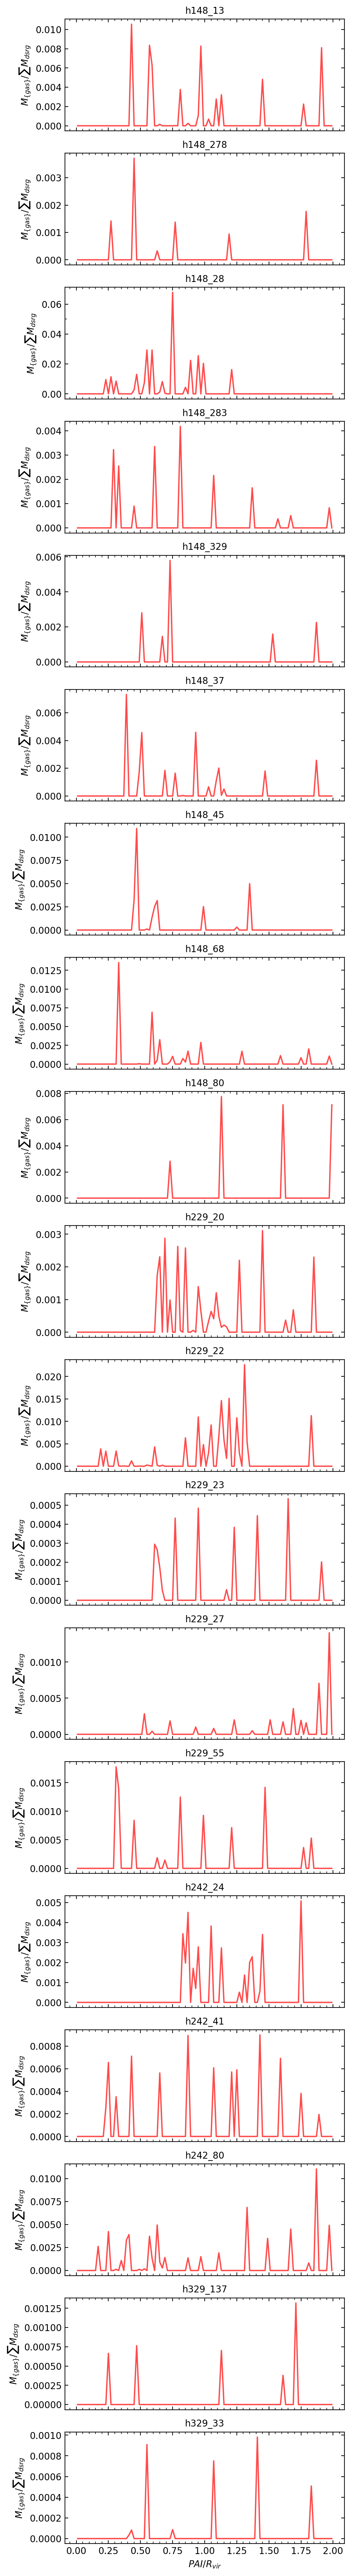

In [16]:
### Making panels of the discharge plots above for each satellite ###

# plotting hot reaccreted per hot discharged.
hot_dsrg = discharged[discharged.sneHeated==True]
hot_reac = reaccreted[reaccreted.sneHeated==True]


# running loop for each sat.
bins = 100
fig, ax = plt.subplots(19, 1, dpi=200, figsize=(5.5,50), sharex=True,
                       constrained_layout=False)

for i in range(0,len(keys)):
    key = keys[i]
    hot1 = hot_dsrg[hot_dsrg['key']==key]
    sn = sntotal[sntotal['key']==key]

    y1, x = np.histogram(pai(hot1), bins=bins, weights=wt(hot1, sntotal),
                     range=(0, 2))
    bincenters = 0.5*(x[1:] + x[:-1])
    sum1 = np.cumsum(y1)
    ax[i].plot(bincenters, y1, alpha=0.7, color='r')     
    
    ax[i].set_title(f'{key}', fontsize='medium')
    ax[i].set_ylabel('$M_{\{gas\}} / \sum M_{dsrg}$')
    
    ax[i].tick_params(direction='in', which='both', top=True, right=True)
    ax[i].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
    ax[i].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
#     ax.grid(alpha=0.1, zorder=-1000)
    
    i += 1

# ax[0].legend(frameon=False, fontsize=7)
ax[-1].set_xlabel(r'$PAI / R_{vir}$')

plt.show()

### Proportion of SN-gas Never Returning to Satellite
___

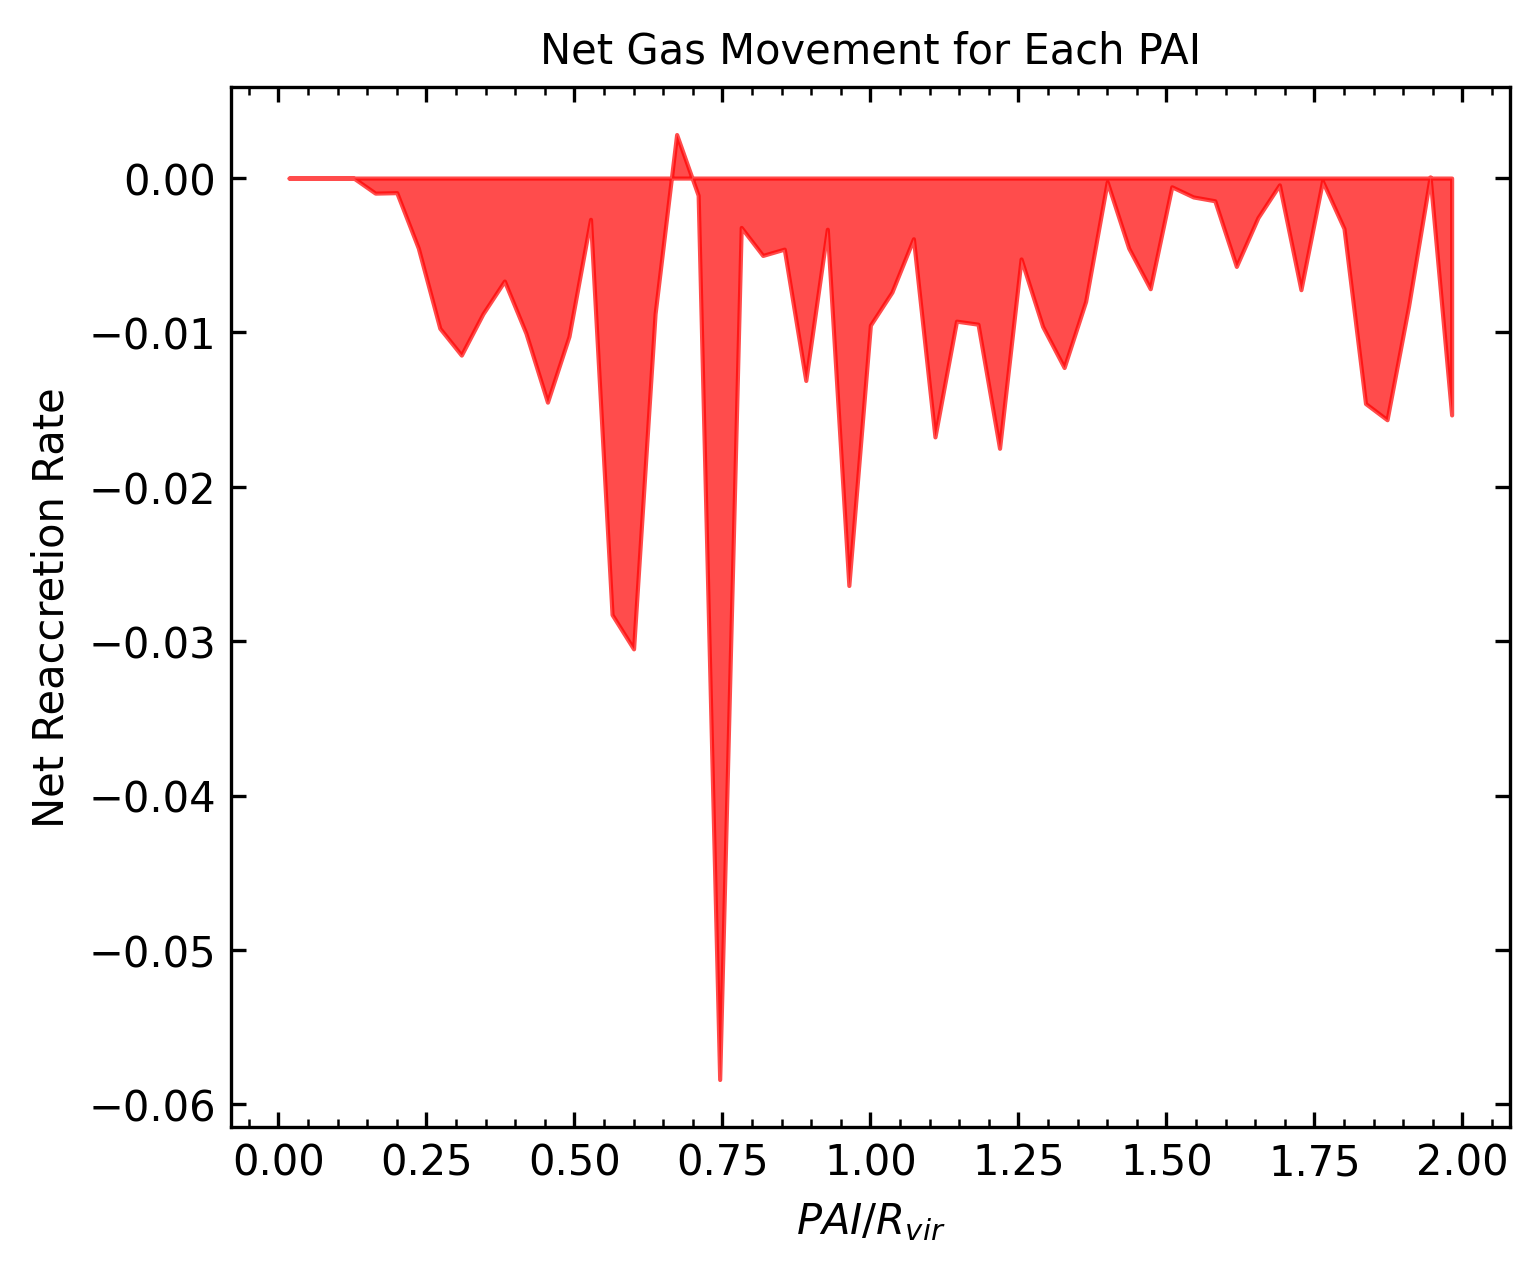

In [136]:
# plotting hot reaccreted per hot discharged.
hot_dsrg = discharged[discharged.sneHeated==True]
hot_reac = reaccreted[reaccreted.sneHeated==True]


bins = 55
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(5.5,4.5), sharex=True,
                       constrained_layout=False)
gs = plt.GridSpec(2,1)

y1, x = np.histogram(pai(hot_dsrg), bins=bins, weights=wt(hot_dsrg, sntotal),
                     range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)
y2, x = np.histogram(pai(hot_reac), bins=bins, weights=wt(hot_reac, sntotal),
                     range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum2 = np.cumsum(y2)

y3, x = np.histogram(pai(sntotal), bins=bins, weights=wt(sntotal), range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum3 = np.cumsum(y3)

ax.stackplot(bincenters, y2-y1, alpha=0.7, color='r')

ax.set_title('Net Gas Movement for Each PAI',
             fontsize='medium')
ax.set_xlabel(r'$PAI / R_{vir}$')
ax.set_ylabel('Net Reaccretion Rate')
# # ax[1].set_xlim(-0.1,4)
# ax[1].set_ylim(0,0.2)
                                                                                    
ax.tick_params(direction='in', which='both', top=True, right=True)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
# ax.grid(alpha=0.1, zorder=-1000)

plt.show()

In [41]:
# percent of sn gas discharged vs. percent discharged at each pai.

### Fractions of Rates:  Reaccretion / Discharged<a class="anchor" id="fracs"></a>
___

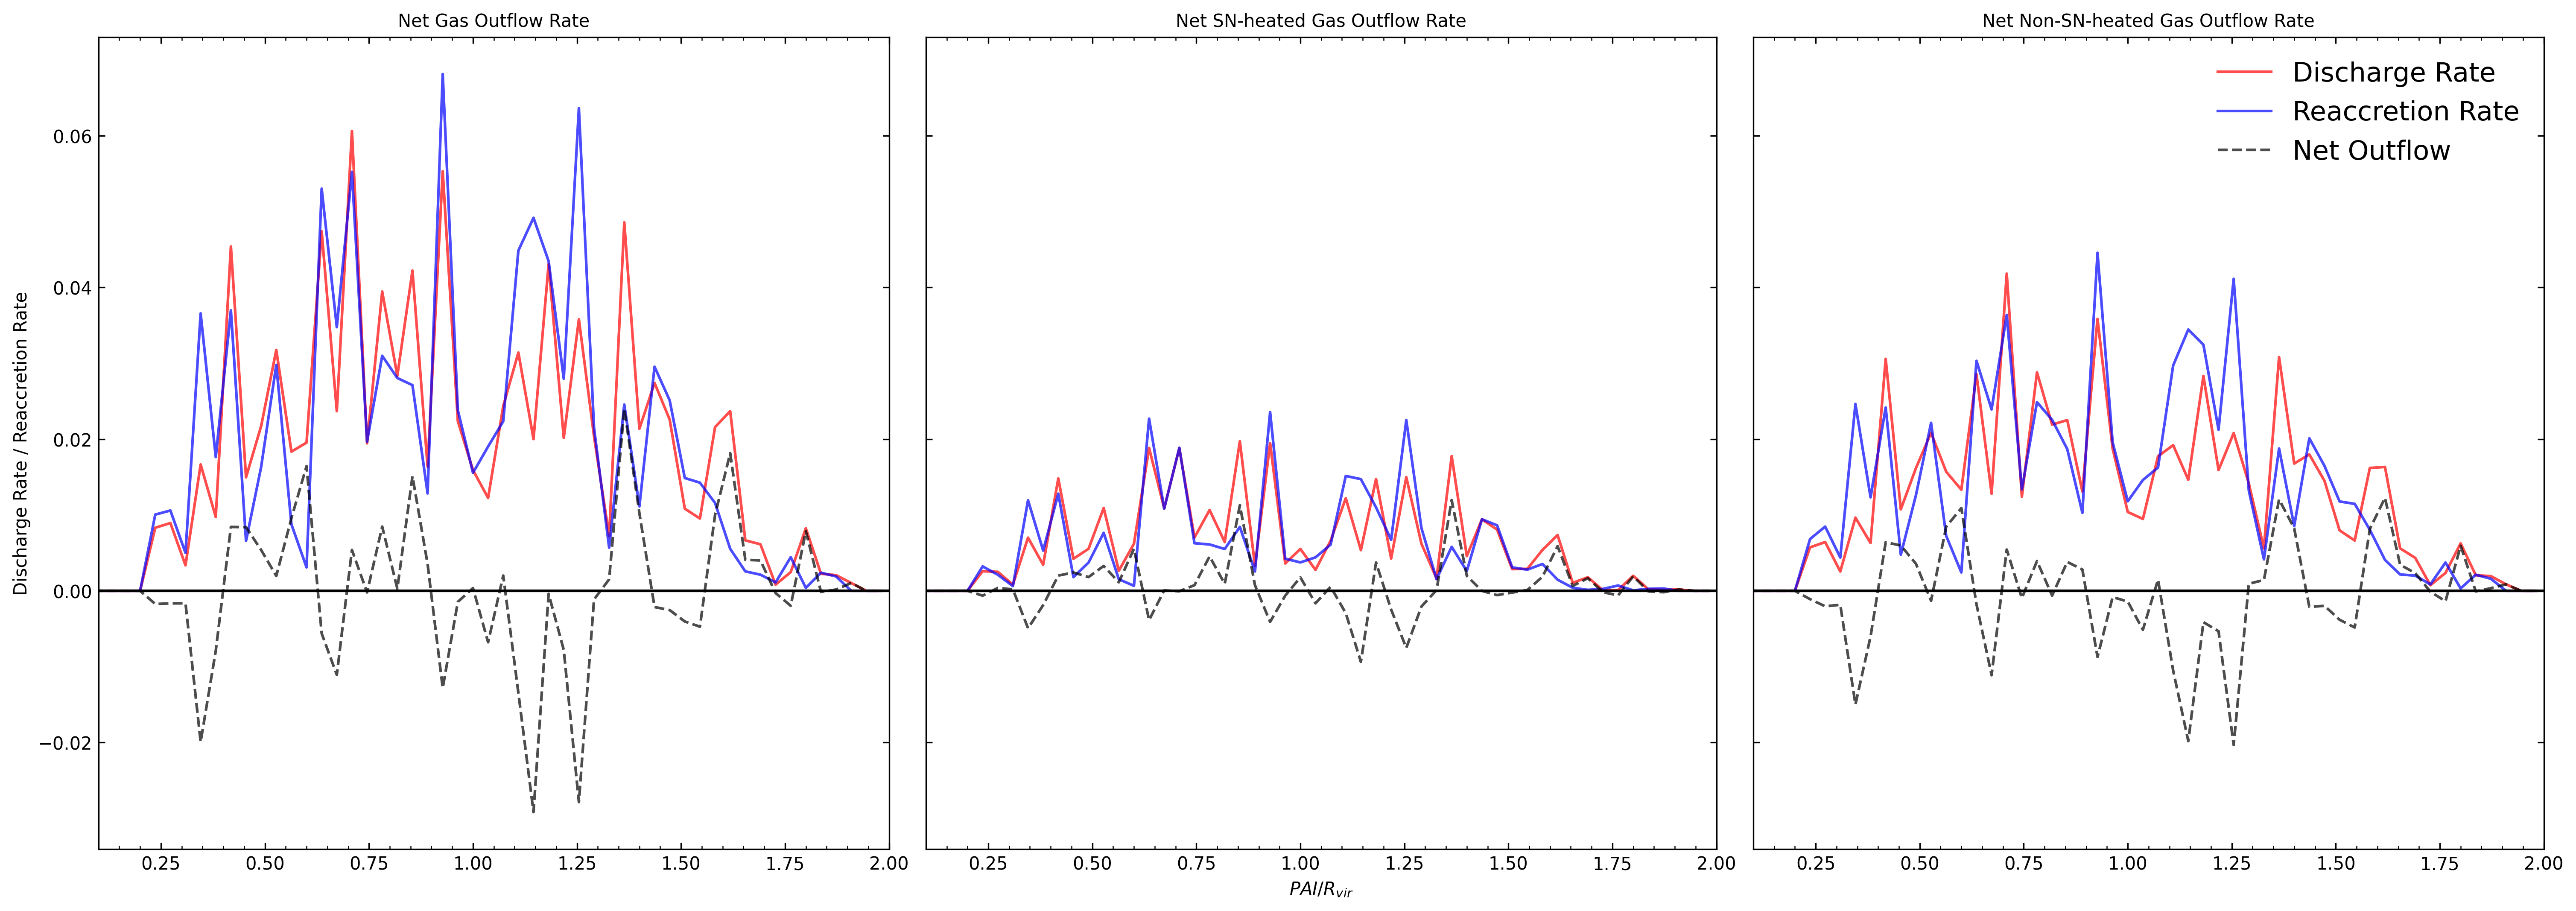

In [64]:
hot_dsrg = discharged[discharged.sneHeated==True]
hot_reac = reaccreted[reaccreted.sneHeated==True]
cold_dsrg = discharged[discharged.sneHeated==False]
cold_reac = reaccreted[reaccreted.sneHeated==False]


# plotting hot reaccreted per hot discharged.
bins = 55
fig, ax = plt.subplots(1, 3, dpi=300, figsize=(20,7), sharey=True,
                       constrained_layout=True)

### all gas ###
y1, x = np.histogram(pai(discharged), bins=bins, weights=wt(discharged),
                     range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)
y2, x = np.histogram(pai(reaccreted), bins=bins, weights=wt(reaccreted),
                     range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum2 = np.cumsum(y2)

ax[0].plot(bincenters, y1, alpha=0.7, color='r', label='Discharge Rate')
ax[0].plot(bincenters, y2, alpha=0.7, color='b', label='Reaccretion Rate')
ax[0].plot(bincenters, y1-y2, alpha=0.7, linestyle='--', color='black', label='Net Outflow')
ax[0].axhline(y=0, color='black')




ax[0].set_title('Net Gas Outflow Rate', fontsize='medium')
ax[0].set_ylabel('Discharge Rate / Reaccretion Rate')
ax[0].set_xlim(0.1,2.0)
                                                                                    
ax[0].tick_params(direction='in', which='both', top=True, right=True)
ax[0].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax[0].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))


### sn-heated gas ###
y1, x = np.histogram(pai(hot_dsrg), bins=bins, weights=wt(hot_dsrg, discharged),
                     range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)
y2, x = np.histogram(pai(hot_reac), bins=bins, weights=wt(hot_reac, reaccreted),
                     range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum2 = np.cumsum(y2)

ax[1].plot(bincenters, y1, alpha=0.7, color='r', label='Discharge Rate')
ax[1].plot(bincenters, y2, alpha=0.7, color='b', label='Reaccretion Rate')
ax[1].plot(bincenters, y1-y2, alpha=0.7, linestyle='--', color='black', label='Net Outflow')
ax[1].axhline(y=0, color='black')




ax[1].set_title('Net SN-heated Gas Outflow Rate', fontsize='medium')
ax[1].set_xlabel(r'$PAI / R_{vir}$')
ax[1].set_xlim(0.1,2.0)
# ax[1].set_ylim(0,0.2)
                                                                                    
ax[1].tick_params(direction='in', which='both', top=True, right=True)
ax[1].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax[1].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))
# ax.grid(alpha=0.1, zorder=-1000)


### non-sn-heated gas ###
y1, x = np.histogram(pai(cold_dsrg), bins=bins, weights=wt(cold_dsrg, discharged),
                     range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)
y2, x = np.histogram(pai(cold_reac), bins=bins, weights=wt(cold_reac, reaccreted),
                     range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum2 = np.cumsum(y2)

ax[2].plot(bincenters, y1, alpha=0.7, color='r', label='Discharge Rate')
ax[2].plot(bincenters, y2, alpha=0.7, color='b', label='Reaccretion Rate')
ax[2].plot(bincenters, y1-y2, alpha=0.7, linestyle='--', color='black', label='Net Outflow')
ax[2].axhline(y=0, color='black')



ax[2].set_title('Net Non-SN-heated Gas Outflow Rate', fontsize='medium')
ax[2].set_xlim(0.1,2.0)
# ax[1].set_ylim(0,0.2)
                                                                                    
ax[2].tick_params(direction='in', which='both', top=True, right=True)
ax[2].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax[2].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))
# ax.grid(alpha=0.1, zorder=-1000)

ax[2].legend(frameon=False, fontsize=15)

plt.savefig('plots/RperD.pdf')
plt.show()

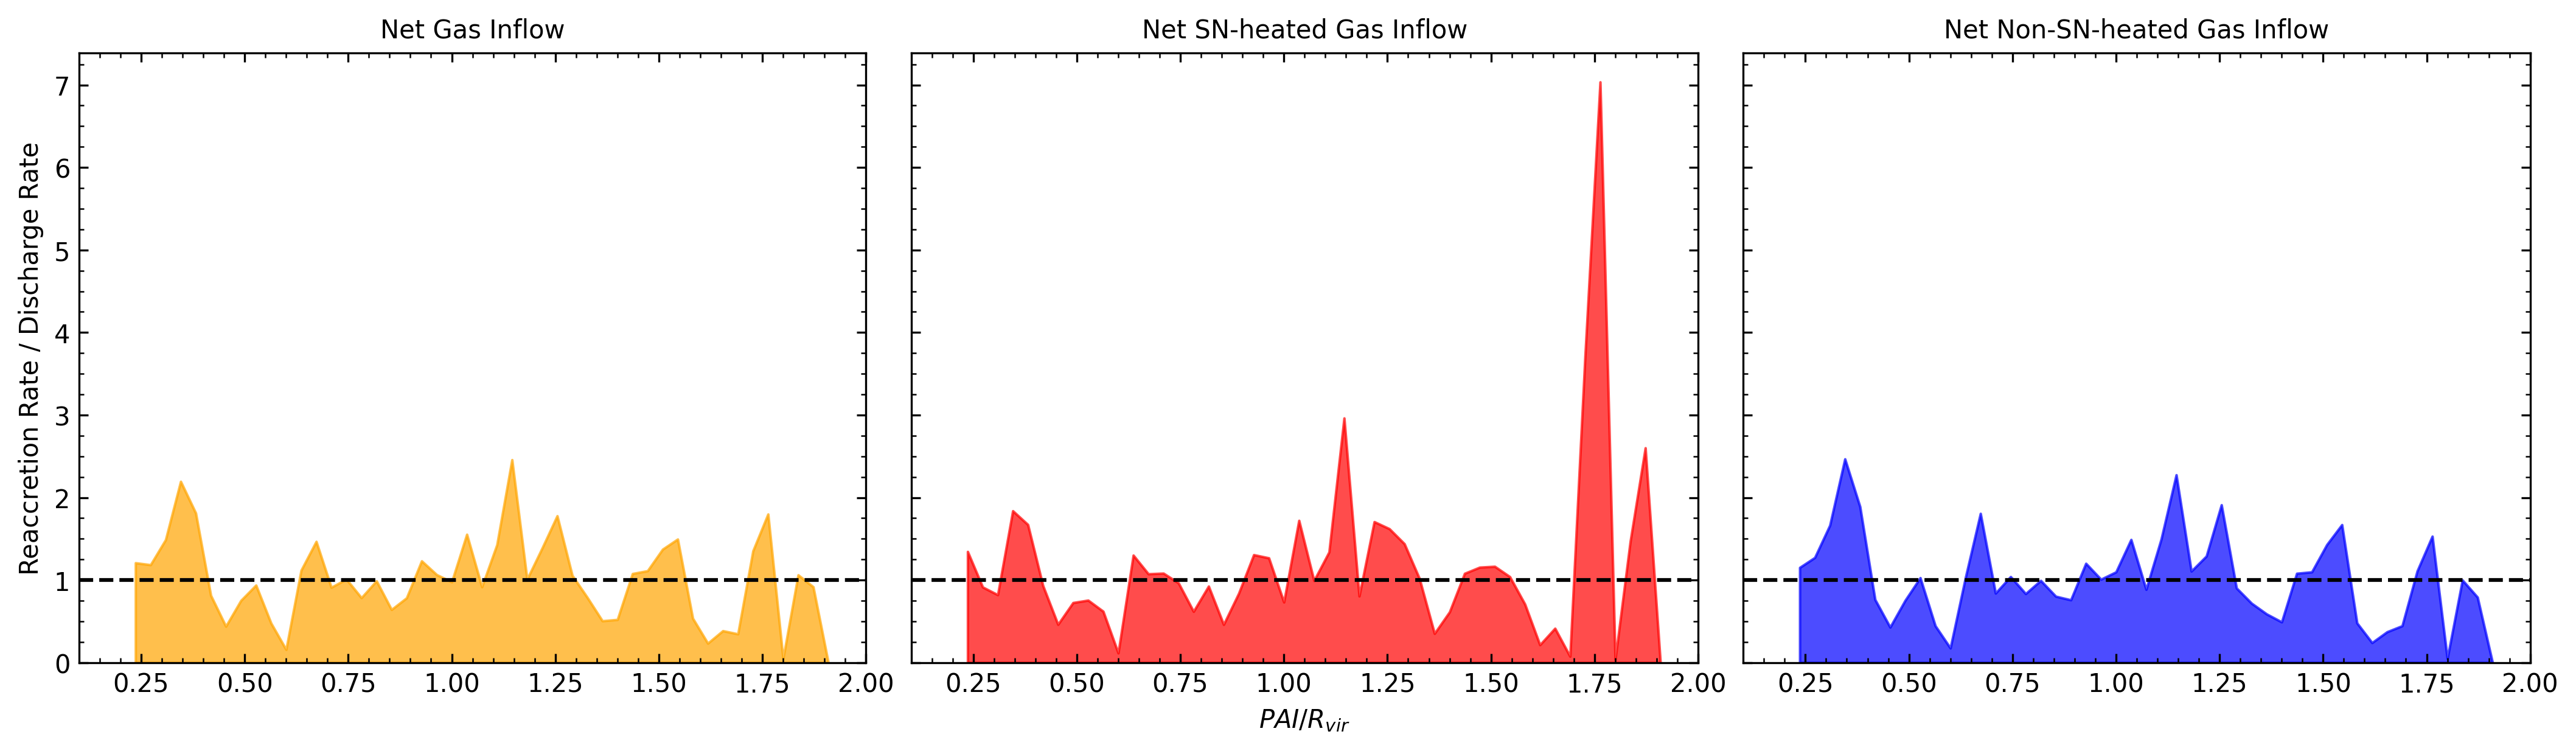

In [50]:
hot_dsrg = discharged[discharged.sneHeated==True]
hot_reac = reaccreted[reaccreted.sneHeated==True]
cold_dsrg = discharged[discharged.sneHeated==False]
cold_reac = reaccreted[reaccreted.sneHeated==False]


# plotting hot reaccreted per hot discharged.
bins = 55
fig, ax = plt.subplots(1, 3, dpi=300, figsize=(14,4), sharey=True,
                       constrained_layout=True)

### all gas ###
y1, x = np.histogram(pai(discharged), bins=bins, weights=wt(discharged),
                     range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)
y2, x = np.histogram(pai(reaccreted), bins=bins, weights=wt(reaccreted),
                     range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum2 = np.cumsum(y2)

ax[0].stackplot(bincenters, y2/y1, alpha=0.7, color='orange')
ax[0].axhline(y=1.0, color='black', linestyle='--')

ax[0].set_title('Net Gas Inflow', fontsize='medium')
ax[0].set_ylabel('Reaccretion Rate / Discharge Rate')
ax[0].set_xlim(0.1,2.0)
                                                                                    
ax[0].tick_params(direction='in', which='both', top=True, right=True)
ax[0].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax[0].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))


### sn-heated gas ###
y1, x = np.histogram(pai(hot_dsrg), bins=bins, weights=wt(hot_dsrg),
                     range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)
y2, x = np.histogram(pai(hot_reac), bins=bins, weights=wt(hot_reac),
                     range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum2 = np.cumsum(y2)

ax[1].stackplot(bincenters, y2/y1, alpha=0.7, color='r')
ax[1].axhline(y=1.0, color='black', linestyle='--')

ax[1].set_title('Net SN-heated Gas Inflow', fontsize='medium')
ax[1].set_xlabel(r'$PAI / R_{vir}$')
ax[1].set_xlim(0.1,2.0)
# ax[1].set_ylim(0,0.2)
                                                                                    
ax[1].tick_params(direction='in', which='both', top=True, right=True)
ax[1].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax[1].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))
# ax.grid(alpha=0.1, zorder=-1000)


### non-sn-heated gas ###
y1, x = np.histogram(pai(cold_dsrg), bins=bins, weights=wt(cold_dsrg),
                     range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)
y2, x = np.histogram(pai(cold_reac), bins=bins, weights=wt(cold_reac),
                     range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum2 = np.cumsum(y2)

ax[2].stackplot(bincenters, y2/y1, alpha=0.7, color='b')
ax[2].axhline(y=1.0, color='black', linestyle='--')

ax[2].set_title('Net Non-SN-heated Gas Inflow', fontsize='medium')
ax[2].set_xlim(0.1,2.0)
# ax[1].set_ylim(0,0.2)
                                                                                    
ax[2].tick_params(direction='in', which='both', top=True, right=True)
ax[2].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax[2].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))
# ax.grid(alpha=0.1, zorder=-1000)



plt.savefig('plots/RperD.pdf')
plt.show()

### Gas Fractions [WIP]<a class="anchor" id="fractions"></a>
___
___


Visualizing:
1. The fraction of disk gas heated by SN that ends up discharged, and 
2. How this fraction compares to the total discharge mass/mass in disk?

In [37]:
# getting SN gas in the satellite disk.
sntotal = pd.DataFrame()
keys = get_keys()

for i,key in enumerate(keys):
    i += 1
    sim = key[:4]
    haloid = int(key[5:])
    sntotal1 = pd.read_hdf(f'{rootPath}Stellar_Feedback_Code/SNeData/sngas_particles.hdf5',
                           key=key)
    sntotal1['key'] = key
    sntotal = pd.concat([sntotal, sntotal1[sntotal1['sat_disk'] == False]])
    
    

hot_dsrg = discharged[discharged.sneHeated==True]

# fraction of disk gas heated by SN that ends up discharged:

times = np.intersect1d(sntotal['time'], hot_dsrg['time'])
fracs = []

# for i,t in enumerate(times):
#     i+=1
#     s1 = sum(hot_dsrg[hot_dsrg['time'] == t]['mass'])
#     s2 = sum(sntotal[sntotal['time'] == t]['mass'])
#     fracs = np.append(fracs, s1/s2)  # SN-heated discharge/all SN-heated at each shared timestep

    
# # plotting procedure:
# fig, ax = plt.subplots(1, 1, dpi=300, figsize=(5.5,4.5), sharex=True,
#                        constrained_layout=False)

# ax.stackplot(bincenters, y2-y1, alpha=0.7, color='r')

# ax.set_title('Net Gas Movement for Each PAI',
#              fontsize='medium')
# ax.set_xlabel(r'$PAI / R_{vir}$')
# ax.set_ylabel('Net Reaccretion Rate')
# # # ax[1].set_xlim(-0.1,4)
# # ax[1].set_ylim(0,0.2)
                                                                                    
# ax.tick_params(direction='in', which='both', top=True, right=True)
# ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
# ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
# # ax.grid(alpha=0.1, zorder=-1000)

# plt.show()
    
    
    
    
    
# How does this fraction compare to the total discharge mass/mass in disk?

array([4.15862344e+00, 1.16248396e+02, 1.30092641e+00, 5.08659750e+00,
       4.23752508e+00, 1.17502251e+02, 2.16444336e+01, 3.09389759e+00,
       8.29571408e+00, 6.46642666e+01, 7.06579260e+00, 5.21029408e+00,
       3.81639647e-01, 3.13579848e+00, 4.17459795e+00, 4.77597365e+01,
       7.49735181e+00, 3.25567856e+00, 3.84758982e+00, 1.95816031e+01,
       2.93114755e+00, 2.20626835e+02, 6.59530634e+00, 6.87176311e-01,
       1.15948276e+01, 2.60435380e+00, 1.40939590e+00, 2.77045489e+00,
       1.42621549e+01, 2.37209192e+01, 5.38523958e+00, 2.69583480e+00,
       1.07443688e+01, 4.78526304e+00, 8.33519193e+00, 3.59917516e-01,
       1.25994987e+01, 2.52334675e+00, 4.47861960e+00, 1.20927464e+01,
       9.80982866e-02, 2.83248357e+00, 2.62213709e+00, 5.48521883e+00,
       8.60656467e-01, 5.52882873e+00, 1.02547007e+01, 7.66999731e-02,
       2.18887947e+00, 1.62517904e+00, 8.75052900e+00, 4.68020271e-02,
       2.46448479e+00, 3.71919929e+00, 1.32030371e+00, 1.11725837e+00,
      

### Inflows, Outflows, and Net <a class="anchor" id="inout"></a>
___
___

Observing raw mass inflows, outflows, and net flows for our satellites accross the range of PAIs.

In [20]:
# collecting mass discharged, reaccreted at each PAI.
discharged['pai'] = pai(discharged)

hot_dsrg = discharged[discharged.sneHeated==True]
hot_reac = reaccreted[reaccreted.sneHeated==True]
cold_dsrg = discharged[discharged.sneHeated==False]
cold_reac = reaccreted[reaccreted.sneHeated==False]

bins = 50
y1, x = np.histogram(pai(hot_dsrg), bins=bins, weights=wt(hot_dsrg),
                     range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)
y2, x = np.histogram(pai(hot_reac), bins=bins, weights=wt(hot_reac),
                     range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum2 = np.cumsum(y2)

In [17]:
pai(hot_dsrg)

array([1.60598805, 1.47914644, 1.28497265, ..., 1.27822508, 0.89378406,
       1.27822508])

In [15]:
len(pai(hot_dsrg))

62010

In [16]:
len(hot_dsrg)

62010

## Satellite Disk Mass [WIP]  <a class="anchor" id="diskmass"></a>

---
---

In [127]:
# Need to recover `sat_Mvir` key from particle tracking to complete this description.
np.unique(discharged['sat_Mvir'])

array([1.81821333e+09, 1.82568874e+09, 1.85755189e+09, 1.86261722e+09,
       1.89744683e+09, 1.94212503e+09, 2.86556787e+09, 2.89157527e+09,
       2.94212128e+09, 3.04145428e+09, 3.17155744e+09, 3.20731845e+09,
       3.32772843e+09, 3.47581239e+09, 3.53417057e+09, 3.54479054e+09,
       3.59677080e+09, 3.68650106e+09, 3.68805881e+09, 3.77767918e+09,
       3.84061335e+09, 3.86409307e+09, 4.02965195e+09, 4.16233626e+09,
       4.24283093e+09, 4.29289104e+09, 4.31029805e+09, 4.31967646e+09,
       4.32983702e+09, 4.38176236e+09, 4.41452432e+09, 4.42650291e+09,
       4.44149682e+09, 4.64170921e+09, 4.93401202e+09, 4.95445587e+09,
       5.25768817e+09, 5.69523174e+09, 5.74978479e+09, 5.80971205e+09,
       5.85354031e+09, 5.86856295e+09, 5.89747988e+09, 5.93310892e+09,
       5.98177902e+09, 6.01306595e+09, 6.01734799e+09, 6.07764133e+09,
       6.10972366e+09, 6.12633059e+09, 6.56025624e+09, 6.67497787e+09,
       6.90694167e+09, 7.28834031e+09, 7.42942149e+09, 8.17904118e+09,
      

In [133]:
read_tracked_particles('h148', 27, verbose=False)

time       pid       rho          temp          mass  \
0         5.181190    874394  0.000059  7.348940e+04  26510.536704   
1         5.181190    887507  0.000049  9.749002e+04  26510.536704   
2         5.181190    918637  0.000221  7.101821e+04  26513.431172   
3         5.181190   1327603  0.000236  8.709341e+04  26510.536704   
4         5.181190   1352639  0.000046  1.341750e+06  32091.601705   
...            ...       ...       ...           ...           ...   
1146591  13.800797  20187248  0.002072  1.996234e+04  26515.695282   
1146592  13.800797  20195566  0.000937  1.258857e+04  18802.417473   
1146593  13.800797  20199814  0.001534  1.348638e+04  19125.128233   
1146594  13.800797  20292785  0.002258  1.479345e+04  26674.656163   
1146595  13.800797  20325242  0.000692  1.428705e+04  26529.198771   

         coolontime           r  r_per_Rvir           x           y  ...  \
0          0.000000  537.761760   18.208170 -140.087800 -286.297519  ...   
1          0.000000  537.820861   18.210171 -140.577379 -289.508980  ...   
2          0.000000  483.466722   16.369784 -161.583501 -337.842785  ...   
3          0.000000  532.286278   18.022774 -157.674490 -227.992314  ...   
4          4.840591  503.983186   17.064455  -48.230393 -381.618581  ...   
...             ...         ...         ...         ...         ...  ...   
1146591    0.000000  281.461034    9.014392 -141.117800  154.464285  ...   
1146592   12.095902   61.216880    1.960602  -30.067059   47.143689  ...   
1146593   11.988157  117.180517    3.752957  -65.758833   86.006244  ...   
1146594    0.000000    3.910480    0.125241    1.481819    3.282249  ...   
1146595    0.000000   23.502410    0.752715   -9.380196   19.268599  ...   

               dt     r_gal  host_r_gal  sat_disk  sat_halo  host_disk  \
0        0.686875  1.577942   19.856793     False     False      False   
1        0.686875  1.577942   19.856793     False     False      False   
2        0.686875  1.577942   19.856793     False     False      False   
3        0.686875  1.577942   19.856793     False     False      False   
4        0.686875  1.577942   19.856793     False     False      False   
...           ...       ...         ...       ...       ...        ...   
1146591  0.430980  1.957801   15.144002     False     False      False   
1146592  0.430980  1.957801   15.144002     False     False      False   
1146593  0.430980  1.957801   15.144002     False     False      False   
1146594  0.430980  1.957801   15.144002     False      True      False   
1146595  0.430980  1.957801   15.144002     False      True      False   

         host_halo  other_sat    IGM      sat_Mvir  
0            False      False   True  1.017447e+10  
1            False      False   True  1.017447e+10  
2            False      False   True  1.017447e+10  
3            False      False   True  1.017447e+10  
4            False      False   True  1.017447e+10  
...            ...        ...    ...           ...  
1146591       True      False  False  3.475812e+09  
1146592       True      False  False  3.475812e+09  
1146593       True      False  False  3.475812e+09  
1146594      False      False  False  3.475812e+09  
1146595      False      False  False  3.475812e+09  

[1146596 rows x 61 columns]

In [46]:
discharged

time      pid       rho          temp          mass  coolontime  \
99277   11.214915  2202002  0.000120  53035.859375  28366.376150   10.908183   
136755  12.507856  2202002  0.000027  16609.818359  29001.936444   12.388833   
59821    9.921974  2857672  0.000126  58067.246094  27134.726367    9.669960   
79674   10.767100  4073949  0.058975   9752.045898  26835.758536    0.000000   
99281   11.214915  4073949  0.000031  54464.347656  26965.973341   11.058858   
...           ...      ...       ...           ...           ...         ...   
7184     8.090307  6628859  0.000822  18859.460938  26521.169903    0.000000   
25187    9.383249  6628979  0.001709  21003.914062  26610.570287    0.000000   
10792    8.413543  6630126  0.063785  11265.299805  26755.941329    8.272644   
21595    9.060013  6630131  0.001204  23144.421875  26557.970752    0.000000   
7199     8.090307  6630196  0.079972  11086.723633  26645.695937    7.904796   

                r  r_per_Rvir         x         y  ...  sat_halo  host_disk  \
99277    6.693904    0.162781  0.587731 -0.193634  ...      True      False   
136755   8.958103    0.209825  8.207232 -3.552488  ...      True      False   
59821    8.011770    0.198157 -0.151030  8.010301  ...      True      False   
79674    0.870948    0.021428 -0.690207 -0.460012  ...      True      False   
99281   11.675638    0.283926 -5.617107  8.350599  ...      True      False   
...           ...         ...       ...       ...  ...       ...        ...   
7184     5.384164    0.218497 -4.806755  2.301936  ...      True      False   
25187    2.229345    0.097422 -1.015020 -1.822756  ...      True      False   
10792    0.835664    0.033996 -0.760962 -0.129551  ...      True      False   
21595    9.886269    0.435136  5.626673 -2.606279  ...      True      False   
7199     0.850678    0.034522  0.807611 -0.085933  ...      True      False   

        host_halo  other_sat    IGM  sat_Mvir       angle  sneHeated      key  \
99277       False      False  False       NaN  131.989918       True  h148_12   
136755      False      False  False       NaN   41.252153       True  h148_12   
59821       False      False  False       NaN   94.688810       True  h148_12   
79674       False      False  False       NaN   11.985810      False  h148_12   
99281       False      False  False       NaN   54.201828       True  h148_12   
...           ...        ...    ...       ...         ...        ...      ...   
7184        False      False  False       NaN   79.283222      False  h329_29   
25187       False      False  False       NaN   55.631157      False  h329_29   
10792       False      False  False       NaN   53.957536       True  h329_29   
21595       False      False  False       NaN   52.014643      False  h329_29   
7199        False      False  False       NaN  133.722756       True  h329_29   

             pai  
99277   1.605988  
136755  1.479146  
59821   1.284973  
79674   1.566951  
99281   1.605988  
...          ...  
7184    1.278225  
25187   0.769606  
10792   0.893784  
21595   0.500343  
7199    1.278225  

[192116 rows x 65 columns]

## Discriminating Between Satellites<a class="anchor" id="disc"></a>
---
---

### Code Testing <a class="anchor" id="proving"></a>

Testing out different data types and computations.

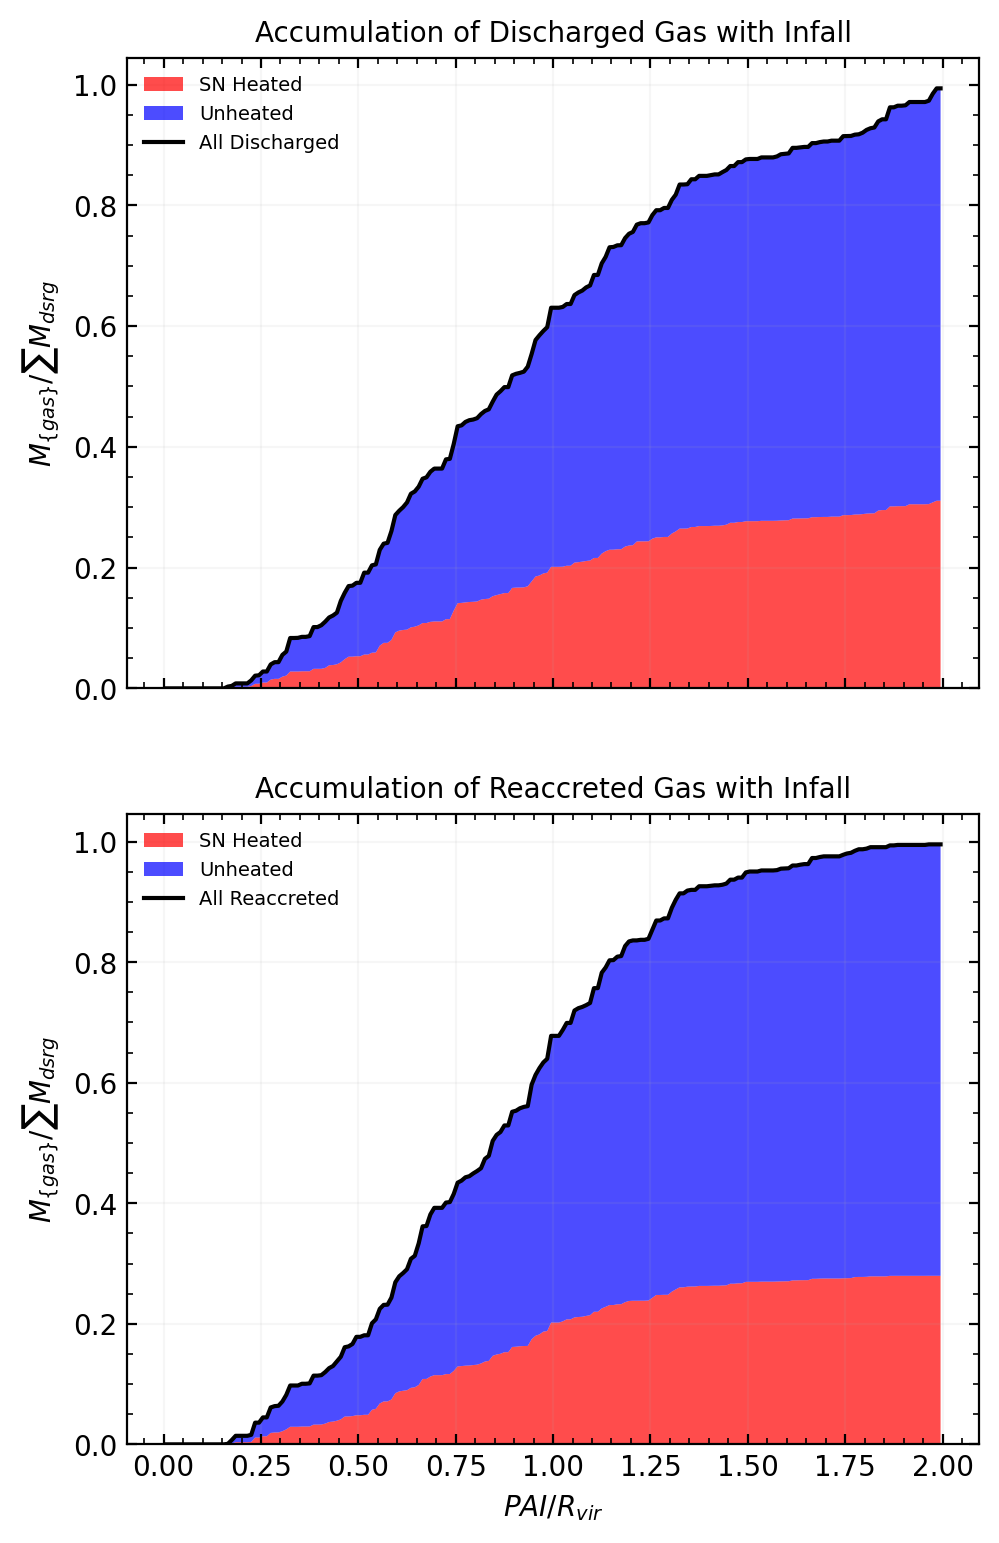

In [10]:
# Basic visualization of discharged/reaccreted gas as a function of POI.

hot = discharged[discharged.sneHeated==True]
cold = discharged[discharged.sneHeated==False]

bins = 200
fig, ax = plt.subplots(2,1, dpi=200, figsize=(5.5,9), sharex=True,
                       constrained_layout=False)

y1, x = np.histogram(pai(hot), bins=bins, weights=wt(hot,discharged), range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)
y2, x = np.histogram(pai(cold), bins=bins, weights=wt(cold,discharged), range=(0, 2))
sum2 = np.cumsum(y2)
ax[0].stackplot(bincenters, sum1, sum2, alpha=0.7, colors=['r', 'b'], 
             labels=['SN Heated', 'Unheated'])         

y3, x = np.histogram(pai(discharged), bins=bins, weights=wt(discharged), range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum3 = np.cumsum(y3)
ax[0].plot(bincenters, sum3, alpha=1.0, c='black', label='All Discharged')

# y4, x = np.histogram(pai(hot)/len(discharged), bins=bins, weights=wt(hot,discharged), range=(0, 2))
# ax.plot(bincenters, y4, alpha=1.0, c='black', label='All Discharged')

ax[0].set_title('Accumulation of Discharged Gas with Infall', fontsize='medium')
# ax[0].set_xlabel(r'$PAI / R_{vir}$')
ax[0].set_ylabel('$M_{\{gas\}} / \sum M_{dsrg}$')
# # ax[0].set_xlim(-0.1,4)
# ax[0].set_ylim(0,0.2)

ax[0].tick_params(direction='in', which='both', top=True, right=True)
ax[0].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax[0].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax[0].grid(alpha=0.1, zorder=-1000)

ax[0].legend(frameon=False, fontsize=7)


hot = reaccreted[reaccreted.sneHeated==True]
cold = reaccreted[reaccreted.sneHeated==False]

y1, x = np.histogram(pai(hot), bins=bins, weights=wt(hot,reaccreted), range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)
y2, x = np.histogram(pai(cold), bins=bins, weights=wt(cold,reaccreted), range=(0, 2))
sum2 = np.cumsum(y2)
ax[1].stackplot(bincenters, sum1, sum2, alpha=0.7, colors=['r', 'b'], 
             labels=['SN Heated', 'Unheated'])         

y3, x = np.histogram(pai(reaccreted), bins=bins, weights=wt(reaccreted), range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum3 = np.cumsum(y3)
ax[1].plot(bincenters, sum3, alpha=1.0, c='black', label='All Reaccreted')

ax[1].set_title('Accumulation of Reaccreted Gas with Infall', fontsize='medium')
ax[1].set_xlabel(r'$PAI / R_{vir}$')
ax[1].set_ylabel('$M_{\{gas\}} / \sum M_{dsrg}$')
# # ax[1].set_xlim(-0.1,4)
# ax[1].set_ylim(0,0.2)

ax[1].tick_params(direction='in', which='both', top=True, right=True)
ax[1].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax[1].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax[1].grid(alpha=0.1, zorder=-1000)

ax[1].legend(frameon=False, fontsize=7)

plt.show()

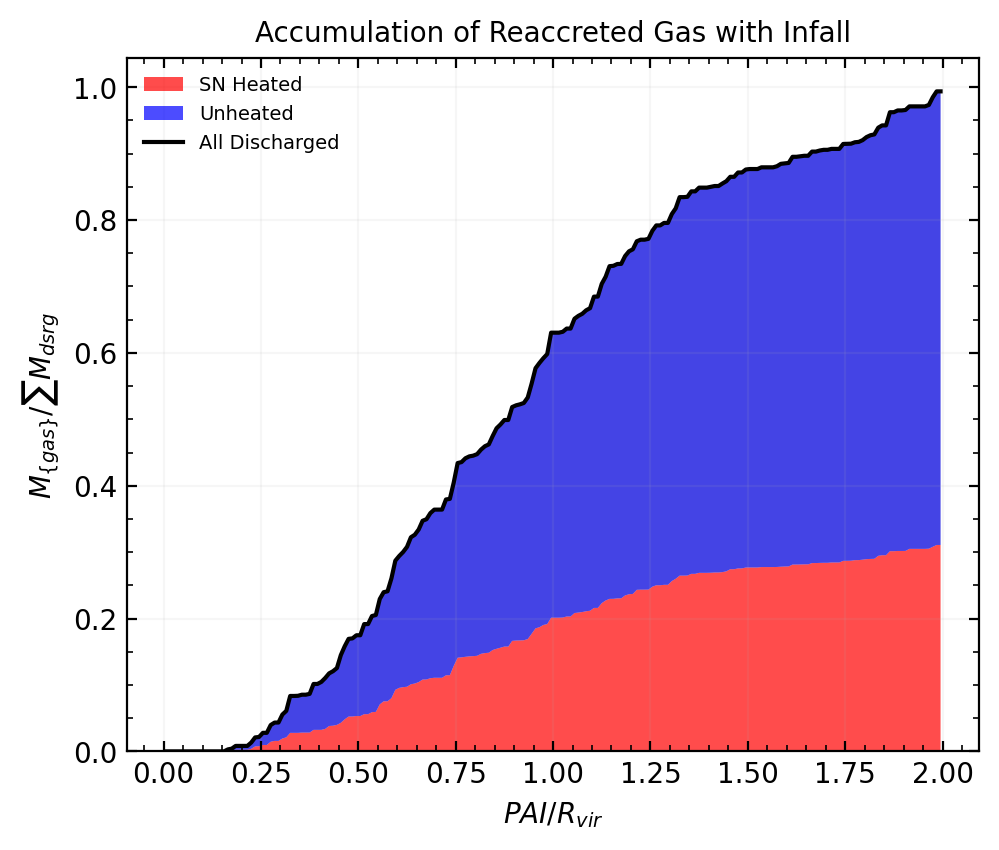

In [11]:
# Basic visualization of reaccreted gas as a function of POI.

hot = reaccreted[reaccreted.sneHeated==True]
cold = reaccreted[reaccreted.sneHeated==False]

bins = 200
fig, ax = plt.subplots(1,1, dpi=200, figsize=(5.5,4.5), sharex=True,
                       constrained_layout=False)


y1, x = np.histogram(pai(hot), bins=bins, weights=wt(hot,discharged), range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)
y2, x = np.histogram(pai(cold), bins=bins, weights=wt(cold,discharged), range=(0, 2))
sum2 = np.cumsum(y2)
ax.stackplot(bincenters, sum1, sum2, alpha=0.7, colors=['r', 'b'], 
             labels=['SN Heated', 'Unheated'])         

y3, x = np.histogram(pai(discharged), bins=bins, weights=wt(discharged), range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum3 = np.cumsum(y3)
ax.plot(bincenters, sum3, alpha=1.0, c='black', label='All Discharged')

ax.fill_between(bincenters, sum1, sum3, color='k', ec=None, alpha=0.1)

ax.set_title('Accumulation of Reaccreted Gas with Infall', fontsize='medium')
ax.set_xlabel(r'$PAI / R_{vir}$')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{dsrg}$')
# # ax[1].set_xlim(-0.1,4)
# ax[1].set_ylim(0,0.2)

ax.tick_params(direction='in', which='both', top=True, right=True)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.grid(alpha=0.1, zorder=-1000)

ax.legend(frameon=False, fontsize=7)

plt.show()

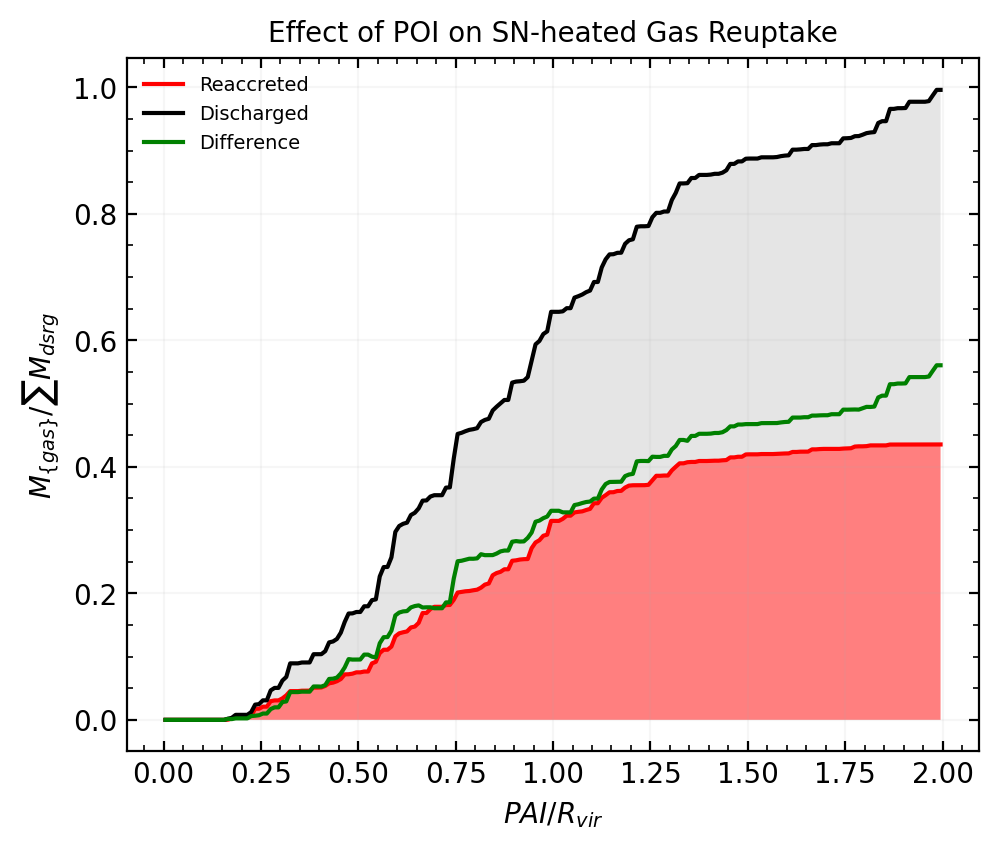

In [227]:
# Basic visualization of reaccreted gas as a function of POI.

hot_dsrg = discharged[discharged.sneHeated==True]
cold_dsrg = discharged[discharged.sneHeated==False]
hot_reac = reaccreted[reaccreted.sneHeated==True]
cold_reac = reaccreted[reaccreted.sneHeated==False]

bins = 200
fig, ax = plt.subplots(1,1, dpi=200, figsize=(5.5,4.5), sharex=True,
                       constrained_layout=False)


y1, x = np.histogram(pai(hot_reac), bins=bins, weights=wt(hot_reac,hot_dsrg), range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)  
ax.plot(bincenters, sum1, alpha=1.0, c='red', label='Reaccreted')
ax.fill_between(bincenters, sum1, y2=0, color='r', ec=None, alpha=0.5)

y2, x = np.histogram(pai(hot_dsrg), bins=bins, weights=wt(hot_dsrg), range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum2 = np.cumsum(y2)
ax.plot(bincenters, sum2, alpha=1.0, c='black', label='Discharged')
ax.fill_between(bincenters, sum1, sum2, color='k', ec=None, alpha=0.1)

ax.plot(bincenters, sum2-sum1, alpha=1.0, c='g', label='Difference')

ax.set_title('Effect of POI on SN-heated Gas Reuptake', fontsize='medium')
ax.set_xlabel(r'$PAI / R_{vir}$')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{dsrg}$')
# # ax[1].set_xlim(-0.1,4)
# ax[1].set_ylim(0,0.2)

ax.tick_params(direction='in', which='both', top=True, right=True)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.grid(alpha=0.1, zorder=-1000)

ax.legend(frameon=False, fontsize=7)

plt.show()

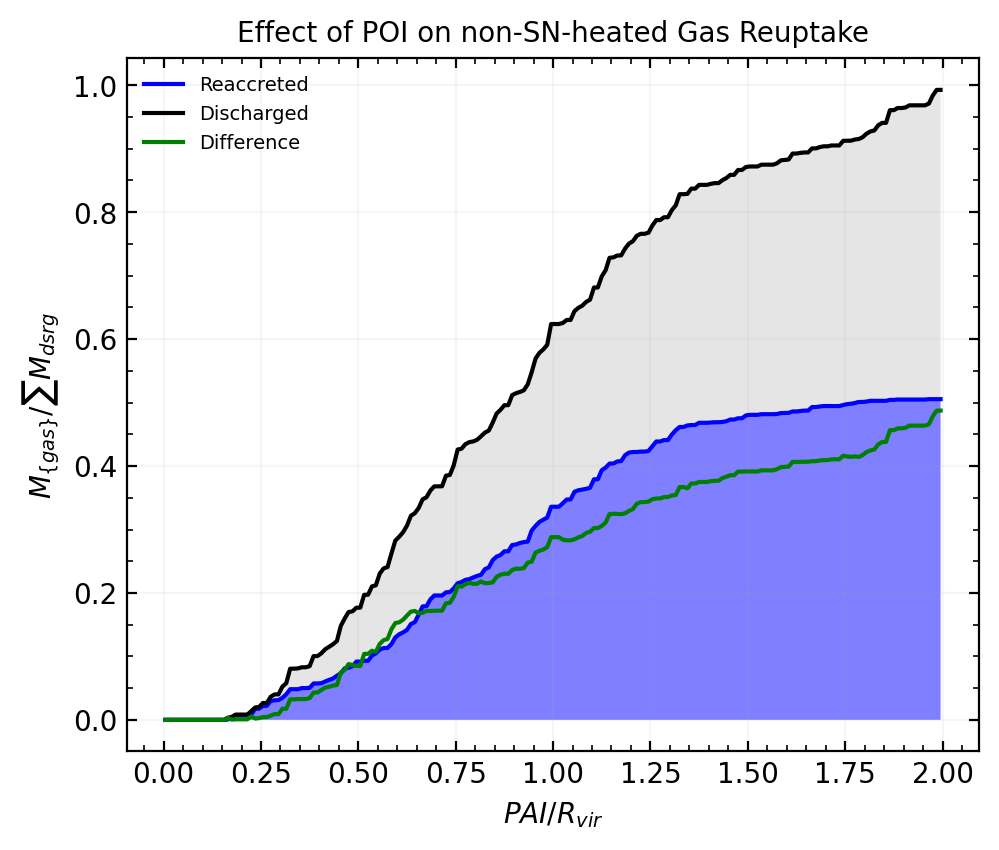

In [226]:
bins = 200
fig, ax = plt.subplots(1,1, dpi=200, figsize=(5.5,4.5), sharex=True,
                       constrained_layout=False)


y1, x = np.histogram(pai(cold_reac), bins=bins, weights=wt(cold_reac,cold_dsrg), range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)  
ax.plot(bincenters, sum1, alpha=1.0, c='b', label='Reaccreted')
ax.fill_between(bincenters, sum1, y2=0, color='b', ec=None, alpha=0.5)

y2, x = np.histogram(pai(cold_dsrg), bins=bins, weights=wt(cold_dsrg), range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum2 = np.cumsum(y2)
ax.plot(bincenters, sum2, alpha=1.0, c='black', label='Discharged')
ax.fill_between(bincenters, sum1, sum2, color='k', ec=None, alpha=0.1)

ax.plot(bincenters, sum2-sum1, alpha=1.0, c='g', label='Difference')

ax.set_title('Effect of POI on non-SN-heated Gas Reuptake', fontsize='medium')
ax.set_xlabel(r'$PAI / R_{vir}$')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{dsrg}$')
# # ax[1].set_xlim(-0.1,4)
# ax[1].set_ylim(0,0.2)

ax.tick_params(direction='in', which='both', top=True, right=True)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.grid(alpha=0.1, zorder=-1000)

ax.legend(frameon=False, fontsize=7)

plt.show()

Justifications for plot directions:
- Discharged:
    - 
- Reaccreted:
    - Is this a reasonable thing to plot against PAI?

This plot actually gives us a unique insight into reaccretion behaviors among the studied satellite galaxies:

- Namely, as satellites approach their host, reaccretions become nearly nonexistent -- contrasting with satellites at 2.00 $PAI/R_{vir}$ recollecting ~45% of their SN-heated, discharged gas.

In [ ]:
ax.plot(bincenters, (sum1[-1]-sum1) / (sum2[-1]-sum2), alpha=1.0, c='g', label='% Reaccreted') # NEEED TO CHANGE TO MASS REACCRETED / MASS DISCHARGED


In [9]:
# collecting mass reaccreted / mass discharged densities.

bins = np.linspace(0, 2, 200)

retention = []

for i in bins:
    retention.append(hot_reacc['mass']/hot_dsrg['mass'])

NameError: name 'hot_reacc' is not defined

In [11]:
# gas retention per PAI:
# essentially, mass reaccreted / mass discharged at each PAI.

hot_dsrg = discharged[discharged.sneHeated==True]
cold_dsrg = discharged[discharged.sneHeated==False]
hot_reacc = reaccreted[reaccreted.sneHeated==True]
cold_reacc = reaccreted[reaccreted.sneHeated==False]

hot_dsrg['pai'] = pai(hot_dsrg)
hot_reacc['pai'] = pai(hot_reacc)

bins=200
y1, x1 = np.histogram(hot_reacc['pai'], bins=bins, range=(0, 2))

retention = []

# for i in len(x):
#     retention append reacc/ dsrg mass in bin





# reacc = np.asarray(hot_reacc['mass'])
# dsrg = np.asarray(hot_dsrg['mass'])

# bins=200
# y1, x1 = np.histogram(hot_reacc['mass'], bins=bins, range=(0, 2))
# # y2, x2 = np.histogram(dsrg, bins=bins, range=(0, 2))


# # bincenters = 0.5*(x[1:] + x[:-1])


# y1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


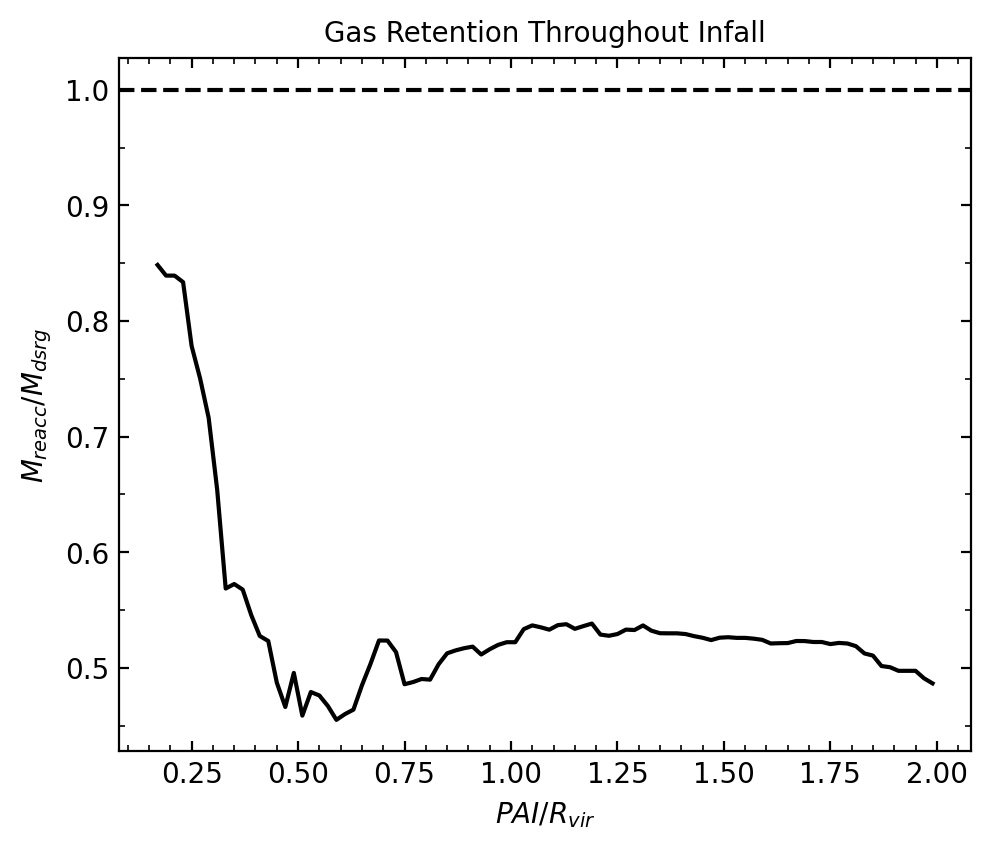

In [151]:
# gas retention per PAI:
# essentially, mass reaccreted / mass discharged at each PAI.
hot_dsrg = discharged[discharged.sneHeated==True]
cold_dsrg = discharged[discharged.sneHeated==False]
hot_reacc = reaccreted[reaccreted.sneHeated==True]
cold_reacc = reaccreted[reaccreted.sneHeated==False]

bins = 100
fig, ax = plt.subplots(1,1, dpi=200, figsize=(5.5,4.5), sharex=True,
                       constrained_layout=False)


y1, x1 = np.histogram(pai(discharged), bins=bins, weights=discharged['mass'], range=(0, 2))
bincenters = 0.5*(x1[1:] + x1[:-1])
sum1 = np.cumsum(y1)

y2, x2 = np.histogram(pai(reaccreted), bins=bins, weights=reaccreted['mass'], range=(0, 2))
sum2 = np.cumsum(y2)
ax.plot(bincenters,sum2/sum1, alpha=1.0, c='k')


# y3, x3 = np.histogram(pai(cold_dsrg), bins=bins, range=(0, 2))
# sum3 = np.cumsum(y3)
# y4, x4 = np.histogram(pai(cold_reacc), bins=bins, range=(0, 2))
# sum4 = np.cumsum(y4)
# ax.plot(bincenters, y4/y3, alpha=1.0, c='b', label='Unheated')

# placing horizontal at 1.00:
ax.axhline(y=1.0, color='black', linestyle='--')

ax.set_title('Gas Retention Throughout Infall', fontsize='medium')
ax.set_xlabel(r'$PAI / R_{vir}$')
ax.set_ylabel('$M_{reacc} / M_{dsrg}$')
# # ax[1].set_xlim(-0.1,4)
# ax[1].set_ylim(0,0.2)

ax.tick_params(direction='in', which='both', top=True, right=True)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
# ax.grid(alpha=0.1, zorder=-1000)

ax.legend(frameon=False, fontsize=7)

plt.show()

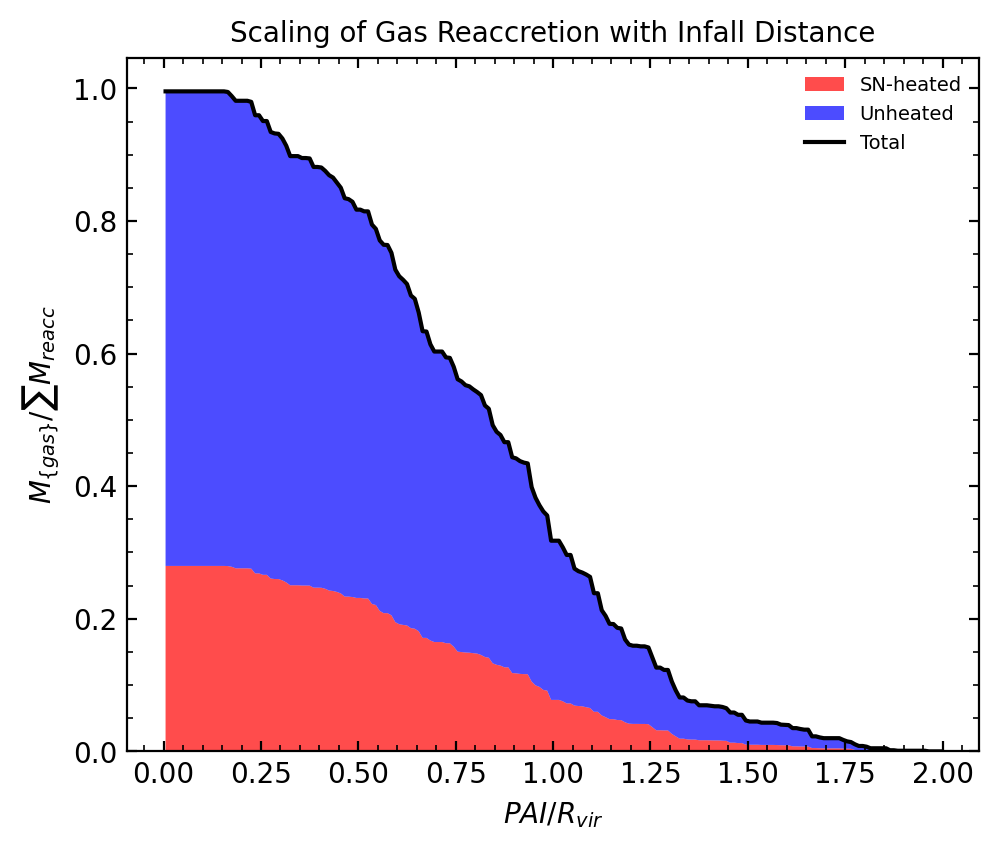

In [12]:
# so we could do % of gas mass discharged at different PAI, and % mass discharged as we
# close in the host galaxy's center.


hot = reaccreted[reaccreted.sneHeated==True]
cold = reaccreted[reaccreted.sneHeated==False]

bins = 200
fig, ax = plt.subplots(1,1, dpi=200, figsize=(5.5,4.5), sharex=True,
                       constrained_layout=False)


y1, x = np.histogram(pai(hot), bins=bins, weights=wt(hot,reaccreted), range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)
y2, x = np.histogram(pai(cold), bins=bins, weights=wt(cold,reaccreted), range=(0, 2))
sum2 = np.cumsum(y2)
ax.stackplot(bincenters, sum1[-1]-sum1, sum2[-1]-sum2, alpha=0.7, colors=['r', 'b'], 
             labels=['SN-heated', 'Unheated'])         

y3, x = np.histogram(pai(reaccreted), bins=bins, weights=wt(reaccreted), range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum3 = np.cumsum(y3)
ax.plot(bincenters, sum3[-1]-sum3, alpha=1.0, c='black', label='Total')









ax.set_title('Scaling of Gas Reaccretion with Infall Distance', fontsize='medium')
ax.set_xlabel(r'$PAI / R_{vir}$')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{reacc}$')
# # ax[1].set_xlim(-0.1,4)
# ax[1].set_ylim(0,0.2)

ax.tick_params(direction='in', which='both', top=True, right=True)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
# ax.grid(alpha=0.1, zorder=-1000)

ax.legend(frameon=False, fontsize=7)

plt.show()

In [79]:
bins = 50
fig = plt.figure(dpi=200, figsize=(5.5,10), constrained_layout=True)
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1], hspace=0) 
ax = fig.add_subplot(gs[:])



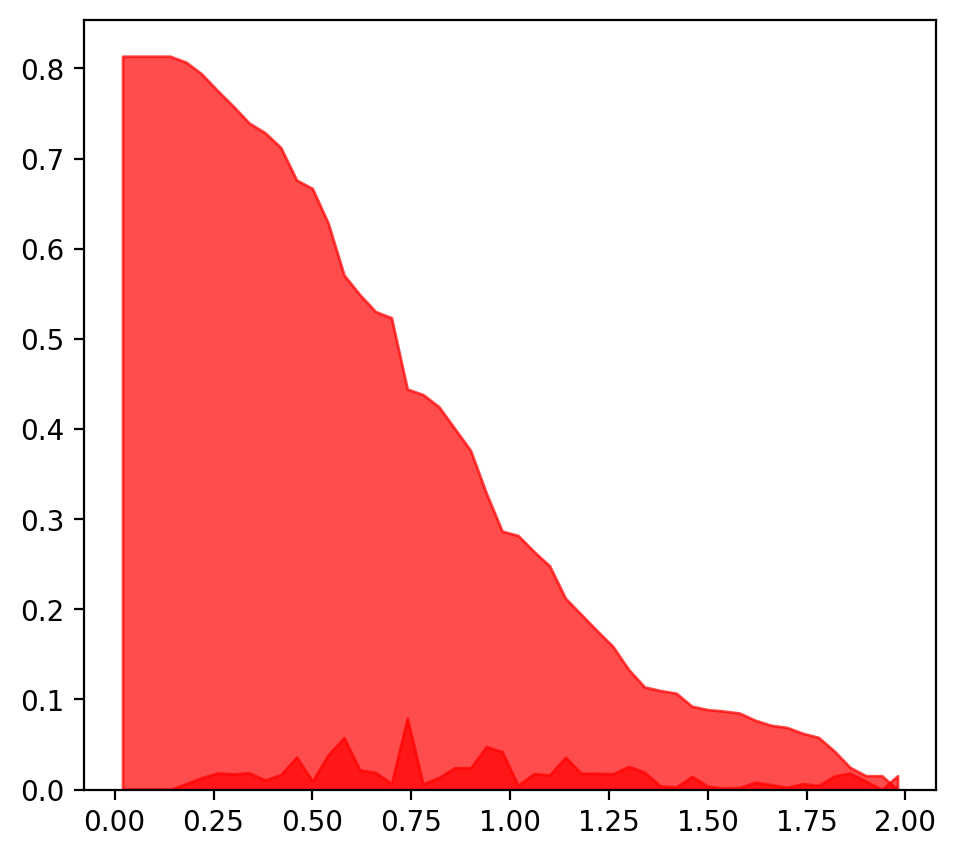

In [82]:
bins = 50
fig = plt.figure(dpi=200, figsize=(5.5,5), constrained_layout=True)
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1], hspace=0) 
ax = fig.add_subplot(gs[:])


y1, x = np.histogram(pai(hot_dsrg), bins=bins, weights=wt(hot_dsrg, sntotal),
                     range=(0, 2))
bincenters = 0.5*(x[1:] + x[:-1])
sum1 = np.cumsum(y1)

ax.stackplot(bincenters, y1, alpha=0.7, color='r')         

ax.stackplot(bincenters, sum1[-1]-sum1, alpha=0.7, color='r')    

# ax[1].text(0, 0.9, 'Accumulation of Discharged Gas with Infall Distance')


# ax[0].set_title('Scaling of Gas Discharge with Infall Distance', fontsize='medium')
# # ax[0].set_xlabel(r'$PAI / R_{vir}$')
# ax[0].set_ylabel('$M_{dsrg} / M_{total}$')
# # # ax[1].set_xlim(-0.1,4)
# # ax[1].set_ylim(0,0.2)
                                                                                    
# ax[0].tick_params(direction='in', which='both', top=True, right=True)
# ax[0].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
# ax[0].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.005))
# # ax.grid(alpha=0.1, zorder=-1000)

# ax[1].set_xlabel(r'$PAI / R_{vir}$')
# ax[1].set_ylabel('$M_{dsrg} / M_{total}$')
# ax[1].set_ylim(0,1)
                                                                                    
# ax[1].tick_params(direction='in', which='both', top=True, right=True)
# ax[1].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
# ax[1].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))

plt.show()